## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


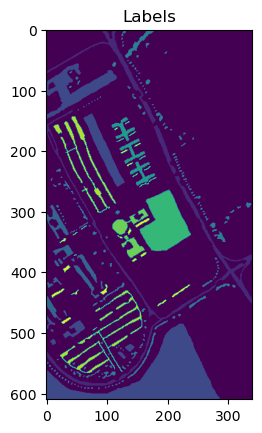

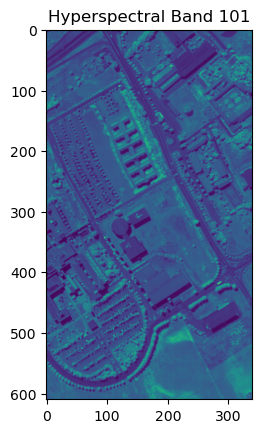

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 5 training sam


All datasets saved to the 'indices' folder.
(45, 5, 5, 103)
(45, 5, 5, 103)
(42686, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1181, PSNR: 7.3423


	 Training Batch [200/535], Loss: 0.0634, PSNR: 7.8286


	 Training Batch [400/535], Loss: 0.0311, PSNR: 13.7768


Epoch [1/50] Training Loss: 0.0555, PSNR: 11.1750
	[Val]   Batch [1/134] Loss: 0.0194, PSNR: 15.3196
	[Val]   Batch [10/134] Loss: 0.0170, PSNR: 17.7007
	[Val]   Batch [20/134] Loss: 0.0181, PSNR: 15.5260
	[Val]   Batch [30/134] Loss: 0.0199, PSNR: 14.9501
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0313
	[Val]   Batch [50/134] Loss: 0.0191, PSNR: 15.1499


	[Val]   Batch [60/134] Loss: 0.0171, PSNR: 15.8598
	[Val]   Batch [70/134] Loss: 0.0163, PSNR: 16.0499
	[Val]   Batch [80/134] Loss: 0.0159, PSNR: 16.0498
	[Val]   Batch [90/134] Loss: 0.0168, PSNR: 16.0173
	[Val]   Batch [100/134] Loss: 0.0191, PSNR: 15.4016
	[Val]   Batch [110/134] Loss: 0.0194, PSNR: 13.9255
	[Val]   Batch [120/134] Loss: 0.0158, PSNR: 15.1208


	[Val]   Batch [130/134] Loss: 0.0174, PSNR: 13.1366
Epoch [1/50] Validation Loss: 0.0182, PSNR: 15.3722

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0188, PSNR: 13.5325


	 Training Batch [200/535], Loss: 0.0133, PSNR: 16.8494


	 Training Batch [400/535], Loss: 0.0081, PSNR: 18.5517


Epoch [2/50] Training Loss: 0.0119, PSNR: 17.2893
	[Val]   Batch [1/134] Loss: 0.0091, PSNR: 18.5963
	[Val]   Batch [10/134] Loss: 0.0073, PSNR: 21.3684
	[Val]   Batch [20/134] Loss: 0.0079, PSNR: 19.1523
	[Val]   Batch [30/134] Loss: 0.0090, PSNR: 18.3811
	[Val]   Batch [40/134] Loss: 0.0080, PSNR: 17.5004
	[Val]   Batch [50/134] Loss: 0.0084, PSNR: 18.7331
	[Val]   Batch [60/134] Loss: 0.0073, PSNR: 19.5855


	[Val]   Batch [70/134] Loss: 0.0071, PSNR: 19.6826
	[Val]   Batch [80/134] Loss: 0.0067, PSNR: 19.7823
	[Val]   Batch [90/134] Loss: 0.0072, PSNR: 19.6961
	[Val]   Batch [100/134] Loss: 0.0086, PSNR: 18.8459
	[Val]   Batch [110/134] Loss: 0.0082, PSNR: 17.6605
	[Val]   Batch [120/134] Loss: 0.0061, PSNR: 19.2734
	[Val]   Batch [130/134] Loss: 0.0073, PSNR: 16.8903


Epoch [2/50] Validation Loss: 0.0082, PSNR: 18.8711

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0073, PSNR: 18.4597


	 Training Batch [200/535], Loss: 0.0062, PSNR: 19.8844


	 Training Batch [400/535], Loss: 0.0060, PSNR: 20.3349


Epoch [3/50] Training Loss: 0.0070, PSNR: 19.5581
	[Val]   Batch [1/134] Loss: 0.0065, PSNR: 20.0552
	[Val]   Batch [10/134] Loss: 0.0051, PSNR: 22.9057
	[Val]   Batch [20/134] Loss: 0.0055, PSNR: 20.6821
	[Val]   Batch [30/134] Loss: 0.0063, PSNR: 19.9563
	[Val]   Batch [40/134] Loss: 0.0057, PSNR: 18.9574
	[Val]   Batch [50/134] Loss: 0.0058, PSNR: 20.3250
	[Val]   Batch [60/134] Loss: 0.0050, PSNR: 21.2105


	[Val]   Batch [70/134] Loss: 0.0050, PSNR: 21.2133
	[Val]   Batch [80/134] Loss: 0.0047, PSNR: 21.3324
	[Val]   Batch [90/134] Loss: 0.0050, PSNR: 21.2533
	[Val]   Batch [100/134] Loss: 0.0061, PSNR: 20.3509
	[Val]   Batch [110/134] Loss: 0.0056, PSNR: 19.3444
	[Val]   Batch [120/134] Loss: 0.0040, PSNR: 21.1293
	[Val]   Batch [130/134] Loss: 0.0050, PSNR: 18.5311
Epoch [3/50] Validation Loss: 0.0058, PSNR: 20.3763

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0059, PSNR: 20.4607


	 Training Batch [200/535], Loss: 0.0052, PSNR: 19.6150


	 Training Batch [400/535], Loss: 0.0053, PSNR: 20.8337


Epoch [4/50] Training Loss: 0.0053, PSNR: 20.8135
	[Val]   Batch [1/134] Loss: 0.0047, PSNR: 21.5202
	[Val]   Batch [10/134] Loss: 0.0037, PSNR: 24.3459
	[Val]   Batch [20/134] Loss: 0.0039, PSNR: 22.2436
	[Val]   Batch [30/134] Loss: 0.0043, PSNR: 21.5531
	[Val]   Batch [40/134] Loss: 0.0040, PSNR: 20.5159
	[Val]   Batch [50/134] Loss: 0.0039, PSNR: 22.0249
	[Val]   Batch [60/134] Loss: 0.0036, PSNR: 22.6262


	[Val]   Batch [70/134] Loss: 0.0036, PSNR: 22.6669
	[Val]   Batch [80/134] Loss: 0.0033, PSNR: 22.8213
	[Val]   Batch [90/134] Loss: 0.0036, PSNR: 22.7653
	[Val]   Batch [100/134] Loss: 0.0043, PSNR: 21.8327
	[Val]   Batch [110/134] Loss: 0.0038, PSNR: 21.0657
	[Val]   Batch [120/134] Loss: 0.0027, PSNR: 22.8213
	[Val]   Batch [130/134] Loss: 0.0034, PSNR: 20.2308
Epoch [4/50] Validation Loss: 0.0041, PSNR: 21.8686

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0036, PSNR: 20.6232


	 Training Batch [200/535], Loss: 0.0043, PSNR: 20.4503


	 Training Batch [400/535], Loss: 0.0038, PSNR: 22.3686


Epoch [5/50] Training Loss: 0.0038, PSNR: 22.2178
	[Val]   Batch [1/134] Loss: 0.0033, PSNR: 22.9773
	[Val]   Batch [10/134] Loss: 0.0027, PSNR: 25.7545
	[Val]   Batch [20/134] Loss: 0.0026, PSNR: 23.9443
	[Val]   Batch [30/134] Loss: 0.0029, PSNR: 23.2627
	[Val]   Batch [40/134] Loss: 0.0027, PSNR: 22.2523
	[Val]   Batch [50/134] Loss: 0.0026, PSNR: 23.8727
	[Val]   Batch [60/134] Loss: 0.0027, PSNR: 23.9150


	[Val]   Batch [70/134] Loss: 0.0026, PSNR: 24.0846
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.2343
	[Val]   Batch [90/134] Loss: 0.0026, PSNR: 24.1608
	[Val]   Batch [100/134] Loss: 0.0030, PSNR: 23.3867
	[Val]   Batch [110/134] Loss: 0.0024, PSNR: 22.9872
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.4610
	[Val]   Batch [130/134] Loss: 0.0023, PSNR: 21.9739
Epoch [5/50] Validation Loss: 0.0029, PSNR: 23.3853

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0037, PSNR: 22.6191


	 Training Batch [200/535], Loss: 0.0035, PSNR: 22.6464


	 Training Batch [400/535], Loss: 0.0030, PSNR: 23.3810


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.3668
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.8590
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7097
	[Val]   Batch [20/134] Loss: 0.0020, PSNR: 25.1112
	[Val]   Batch [30/134] Loss: 0.0023, PSNR: 24.3600
	[Val]   Batch [40/134] Loss: 0.0021, PSNR: 23.4184
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 25.0614
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7955


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0111
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.1616
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0315
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4027
	[Val]   Batch [110/134] Loss: 0.0018, PSNR: 24.2989
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6266
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 23.0584
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.3823

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0033, PSNR: 22.9616


	 Training Batch [200/535], Loss: 0.0045, PSNR: 23.4279


	 Training Batch [400/535], Loss: 0.0020, PSNR: 24.9044


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0213
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.4889
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.3793
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0654
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1854
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.3355
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9441
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4091


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6562
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8394
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6578
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1706
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3061
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5061
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.8681
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1379

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.1224


	 Training Batch [200/535], Loss: 0.0027, PSNR: 23.6820


	 Training Batch [400/535], Loss: 0.0031, PSNR: 25.0781


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5702
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9143
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.8233
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6698
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.7385
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.9260
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4907
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8512


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0903
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3092
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0797
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6648
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9585
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.1378
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3937
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6391

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 24.9080


	 Training Batch [200/535], Loss: 0.0027, PSNR: 23.9611


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3706


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9413
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2306
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1371
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.1047
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.1500
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3715
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8661
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1717


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4132
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6612
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.3854
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 26.0313
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4361
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5792
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7868
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.0116

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0033, PSNR: 23.1627


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.4088


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.5017


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2091
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4609
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4094
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4661
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.4557
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.7295
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1835
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4498


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7011
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9753
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.6601
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.3320
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8196
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9305
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1047
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3190

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.2056


	 Training Batch [200/535], Loss: 0.0026, PSNR: 24.0540


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.1566


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4200
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5955
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.5219
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6100
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5894
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8736
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2706
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6091


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8388
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1302
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8034
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4506
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9157
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0919
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2493
Epoch [11/50] Validation Loss: 0.0015, PSNR: 26.4572

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 25.8471


	 Training Batch [200/535], Loss: 0.0012, PSNR: 25.5085


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8926


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6148
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8526
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7772
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0038
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.9197
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2626
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5769
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8838
	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1054


	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.4365
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0610
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7452
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3065
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4465
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5876
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.7648

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 23.7453


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6176


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8216


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8263
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1071
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0391
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.4025
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2606
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6141
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9327
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1845


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3853
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7387
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3491
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0611
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7393
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8204
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9497
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0861

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.7312


	 Training Batch [200/535], Loss: 0.0012, PSNR: 25.5649


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.5068


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9729
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2668
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2101
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6223
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4471
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8065
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1084
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3735


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5672
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9304
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5488
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.2385
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9391
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0160
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1217
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2732

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.6345


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.7617


	 Training Batch [400/535], Loss: 0.0019, PSNR: 27.1612


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1284
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4166
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3626
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8299
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5930
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0102
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2478
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5563


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7617
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1327
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7173
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3986
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.0698
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2127
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.2978
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4447

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.7575


	 Training Batch [200/535], Loss: 0.0016, PSNR: 27.0425


	 Training Batch [400/535], Loss: 0.0010, PSNR: 26.9546


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3336
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.5860
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5062
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0804
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7876
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1956
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4391
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7575
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.9218


	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.2965
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9037
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5740
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2874
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3212
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4677
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6258

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 25.8928


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.1968


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.3708


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.4867
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8629
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7800
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4809
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.1558
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5652
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7816
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1023


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2672
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6185
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2074
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9228
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6383
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6715
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8514
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9555

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 27.8568


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.9723


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9821


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6554
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0890
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9564
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8123
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4246
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8045
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0046
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.4018


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5496
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8426
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4598
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1787
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8340
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8879
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1154


Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1945

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.5308


	 Training Batch [200/535], Loss: 0.0014, PSNR: 25.0920


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.3069


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.7994
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2903
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0992
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0805
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.6626
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0333
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.2194
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6390
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7963


	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0848
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6986
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.4234
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9696
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9263
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2951
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.4049

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0035


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.5001


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5046


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9874
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4739
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2460
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3097
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8590
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1889
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3959
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.8715


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.0494
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2800
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9290
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.6603
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0836
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0279
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.4786
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.5848

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6615


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.8877


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.9485


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1835
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7776
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4617
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6239
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.2434
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4901
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6910
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.2270


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3931
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5905
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2580
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9619
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2850
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2283
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7562
Epoch [21/50] Validation Loss: 0.0008, PSNR: 28.8833

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8056


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.9691


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.4565


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.3585
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9802
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6433
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.8575
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.5001
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6812
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.9380


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.4400
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.6226
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7952
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5471
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.2288
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4613
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2529


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9451
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.1081

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 25.7260


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.1096


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4075


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5147
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.1859
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7394
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.8980
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6659
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8175
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0544
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6100


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.8383
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 29.9707
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7066
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4060
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4475
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2892
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0438
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.2462

LOG: Epoch [24/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.3076


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.8338


	 Training Batch [400/535], Loss: 0.0015, PSNR: 28.1927


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7445
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5826
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1066
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3702
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.0925
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.1976
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.4919
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 30.0075


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.2669
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3388
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.1240
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7966
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7894
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6509
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4420
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6397

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9128


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.8810


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.3148


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.8779
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8371
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3233
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6101
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4168
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4053
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7621
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2369


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5172
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6061
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4295
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.0863
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9722
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8147
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6207
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.8990

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 29.0646


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.8973


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9723


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0076
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9836
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4510
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.5753
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4790
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4032
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7885
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3016


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6644
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.6911
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5510
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1715
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8695
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8112
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6243
Epoch [26/50] Validation Loss: 0.0007, PSNR: 29.9823

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 28.8111


	 Training Batch [200/535], Loss: 0.0015, PSNR: 28.2864


	 Training Batch [400/535], Loss: 0.0007, PSNR: 29.2927


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.0907
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2541
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6647
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.9217
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8278
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6738
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1048


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5379
	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8847
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9367
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8158
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.4824
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1463
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9175
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8273


Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.2613
Early stopping triggered at epoch 27. No improvement for 3 epochs.


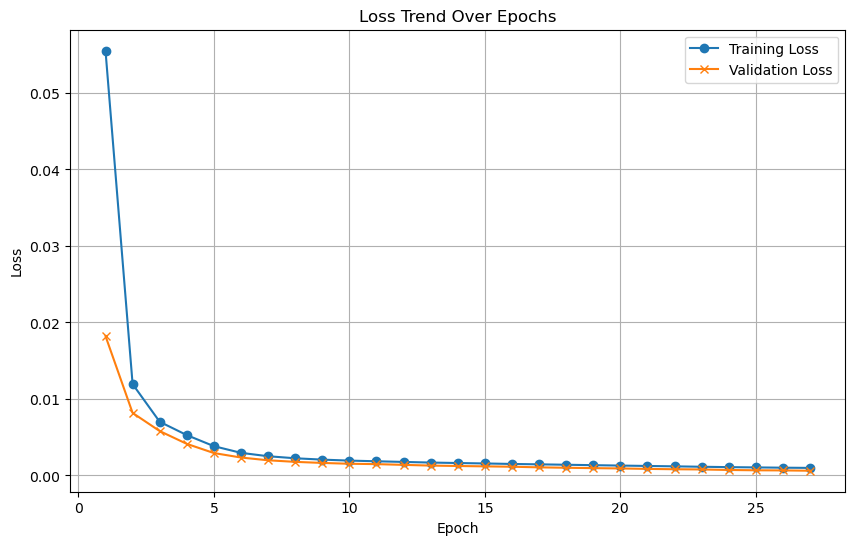

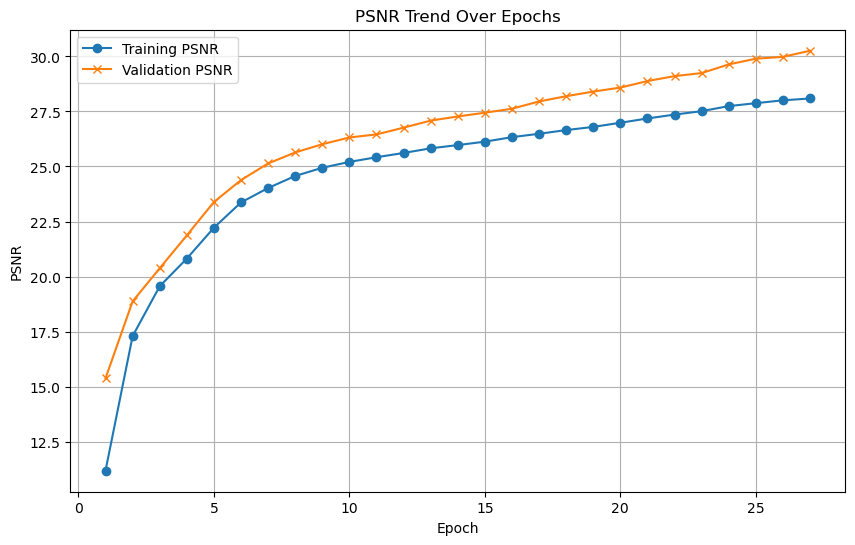

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...


    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1951
    Validation Batch [1/1], Loss: 2.2051
Validation Loss: 2.2051, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2051. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1507
    Validation Batch [1/1], Loss: 2.2050
Validation Loss: 2.2050, Validation Accuracy: 11.11%
Validation loss improved from 2.2051 to 2.2050. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1307
    Validation Batch [1/1], Loss: 2.2049
Validation Loss: 2.2049, Validation Accuracy: 11.11%
Validation loss improved from 2.2050 to 2.2049. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0908
    Validation Batch [1/1], Loss: 2.2048
Validation Loss: 2.2048, Validation Accuracy: 11.11%
Validation loss improved from 2.2049 to 2.2048. Saving model...

LOG: Epoch [5/1000

Epoch [21/1000] completed, Average Training Loss: 1.8678
    Validation Batch [1/1], Loss: 2.1938
Validation Loss: 2.1938, Validation Accuracy: 11.11%
Validation loss improved from 2.1954 to 2.1938. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8602
    Validation Batch [1/1], Loss: 2.1919
Validation Loss: 2.1919, Validation Accuracy: 11.11%
Validation loss improved from 2.1938 to 2.1919. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8381
    Validation Batch [1/1], Loss: 2.1894
Validation Loss: 2.1894, Validation Accuracy: 11.11%
Validation loss improved from 2.1919 to 2.1894. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8633
    Validation Batch [1/1], Loss: 2.1868
Validation Loss: 2.1868, Validation Accuracy: 11.11%
Validation loss improved from 2.1894 to 2.1868. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [55/1000] completed, Average Training Loss: 1.5564
    Validation Batch [1/1], Loss: 1.8399
Validation Loss: 1.8399, Validation Accuracy: 46.67%
Validation loss improved from 1.8566 to 1.8399. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.5556
    Validation Batch [1/1], Loss: 1.8206
Validation Loss: 1.8206, Validation Accuracy: 53.33%
Validation loss improved from 1.8399 to 1.8206. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.4613
    Validation Batch [1/1], Loss: 1.8013
Validation Loss: 1.8013, Validation Accuracy: 53.33%
Validation loss improved from 1.8206 to 1.8013. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.5247
    Validation Batch [1/1], Loss: 1.7837
Validation Loss: 1.7837, Validation Accuracy: 53.33%
Validation loss improved from 1.8013 to 1.7837. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [88/1000] completed, Average Training Loss: 1.2501
    Validation Batch [1/1], Loss: 1.5271
Validation Loss: 1.5271, Validation Accuracy: 57.78%
Validation loss improved from 1.5308 to 1.5271. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.3067
    Validation Batch [1/1], Loss: 1.5188
Validation Loss: 1.5188, Validation Accuracy: 57.78%
Validation loss improved from 1.5271 to 1.5188. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.2216
    Validation Batch [1/1], Loss: 1.5136
Validation Loss: 1.5136, Validation Accuracy: 57.78%
Validation loss improved from 1.5188 to 1.5136. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.2257
    Validation Batch [1/1], Loss: 1.5074
Validation Loss: 1.5074, Validation Accuracy: 57.78%
Validation loss improved from 1.5136 to 1.5074. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [9

Epoch [119/1000] completed, Average Training Loss: 1.0848
    Validation Batch [1/1], Loss: 1.3600
Validation Loss: 1.3600, Validation Accuracy: 68.89%
Validation loss improved from 1.3711 to 1.3600. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.0296
    Validation Batch [1/1], Loss: 1.3511
Validation Loss: 1.3511, Validation Accuracy: 73.33%
Validation loss improved from 1.3600 to 1.3511. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.0260
    Validation Batch [1/1], Loss: 1.3451
Validation Loss: 1.3451, Validation Accuracy: 73.33%
Validation loss improved from 1.3511 to 1.3451. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.0382
    Validation Batch [1/1], Loss: 1.3431
Validation Loss: 1.3431, Validation Accuracy: 73.33%
Validation loss improved from 1.3451 to 1.3431. Saving model...

LOG: Epoch [123/1000] - Training


    Validation Batch [1/1], Loss: 1.1814
Validation Loss: 1.1814, Validation Accuracy: 80.00%
Validation loss improved from 1.1966 to 1.1814. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.7813
    Validation Batch [1/1], Loss: 1.1693
Validation Loss: 1.1693, Validation Accuracy: 80.00%
Validation loss improved from 1.1814 to 1.1693. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.8267
    Validation Batch [1/1], Loss: 1.1601
Validation Loss: 1.1601, Validation Accuracy: 80.00%
Validation loss improved from 1.1693 to 1.1601. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.8037
    Validation Batch [1/1], Loss: 1.1617
Validation Loss: 1.1617, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.7992
    Validation 

Epoch [182/1000] completed, Average Training Loss: 0.6507
    Validation Batch [1/1], Loss: 1.0534
Validation Loss: 1.0534, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.6620
    Validation Batch [1/1], Loss: 1.0656
Validation Loss: 1.0656, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.6384
    Validation Batch [1/1], Loss: 1.0379
Validation Loss: 1.0379, Validation Accuracy: 80.00%
Validation loss improved from 1.0413 to 1.0379. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.6457
    Validation Batch [1/1], Loss: 1.0398
Validation Loss: 1.0398, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training 

Epoch [215/1000] completed, Average Training Loss: 0.4463
    Validation Batch [1/1], Loss: 0.9267
Validation Loss: 0.9267, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.5153
    Validation Batch [1/1], Loss: 0.9142
Validation Loss: 0.9142, Validation Accuracy: 80.00%
Validation loss improved from 0.9201 to 0.9142. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.5100
    Validation Batch [1/1], Loss: 0.9129
Validation Loss: 0.9129, Validation Accuracy: 77.78%
Validation loss improved from 0.9142 to 0.9129. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.5039
    Validation Batch [1/1], Loss: 0.9157
Validation Loss: 0.9157, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Av

Epoch [248/1000] completed, Average Training Loss: 0.3750
    Validation Batch [1/1], Loss: 0.8284
Validation Loss: 0.8284, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.3136
    Validation Batch [1/1], Loss: 0.8274
Validation Loss: 0.8274, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.3960
    Validation Batch [1/1], Loss: 0.8443
Validation Loss: 0.8443, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.3852
    Validation Batch [1/1], Loss: 0.8942
Validation Loss: 0.8942, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.3765
  

    Validation Batch [1/1], Loss: 0.7966
Validation Loss: 0.7966, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.2672
    Validation Batch [1/1], Loss: 0.7436
Validation Loss: 0.7436, Validation Accuracy: 80.00%
Validation loss improved from 0.7578 to 0.7436. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2662
    Validation Batch [1/1], Loss: 0.7600
Validation Loss: 0.7600, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.2858
    Validation Batch [1/1], Loss: 0.7444
Validation Loss: 0.7444, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.2114
    Validation Batch [1/1], Loss: 0.7272
Vali

Epoch [309/1000] completed, Average Training Loss: 0.2131
    Validation Batch [1/1], Loss: 0.7207
Validation Loss: 0.7207, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.1941
    Validation Batch [1/1], Loss: 0.7244
Validation Loss: 0.7244, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.2280
    Validation Batch [1/1], Loss: 0.7257
Validation Loss: 0.7257, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.2461
    Validation Batch [1/1], Loss: 0.7216
Validation Loss: 0.7216, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.2094
  

Epoch [343/1000] completed, Average Training Loss: 0.2019
    Validation Batch [1/1], Loss: 0.6967
Validation Loss: 0.6967, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.1630
    Validation Batch [1/1], Loss: 0.6823
Validation Loss: 0.6823, Validation Accuracy: 82.22%
Validation loss improved from 0.6861 to 0.6823. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.1990
    Validation Batch [1/1], Loss: 0.6756
Validation Loss: 0.6756, Validation Accuracy: 80.00%
Validation loss improved from 0.6823 to 0.6756. Saving model...

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2026
    Validation Batch [1/1], Loss: 0.6798
Validation Loss: 0.6798, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, A

Epoch [374/1000] completed, Average Training Loss: 0.1473
    Validation Batch [1/1], Loss: 0.6998
Validation Loss: 0.6998, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1394
    Validation Batch [1/1], Loss: 0.7002
Validation Loss: 0.7002, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1323
    Validation Batch [1/1], Loss: 0.6995
Validation Loss: 0.6995, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.1298
    Validation Batch [1/1], Loss: 0.7062
Validation Loss: 0.7062, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.1442
  

    Validation Batch [1/1], Loss: 0.6839
Validation Loss: 0.6839, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1012
    Validation Batch [1/1], Loss: 0.6708
Validation Loss: 0.6708, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1262
    Validation Batch [1/1], Loss: 0.6763
Validation Loss: 0.6763, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1089
    Validation Batch [1/1], Loss: 0.6741
Validation Loss: 0.6741, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1092
    Validation Batch [1/1], Loss: 0.6595
Validation Loss: 0.

Epoch [442/1000] completed, Average Training Loss: 0.0891
    Validation Batch [1/1], Loss: 0.6548
Validation Loss: 0.6548, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1002
    Validation Batch [1/1], Loss: 0.6647
Validation Loss: 0.6647, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0858
    Validation Batch [1/1], Loss: 0.6684
Validation Loss: 0.6684, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0869
    Validation Batch [1/1], Loss: 0.6642
Validation Loss: 0.6642, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.088

Epoch [474/1000] completed, Average Training Loss: 0.1193
    Validation Batch [1/1], Loss: 0.6457
Validation Loss: 0.6457, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.6306
Validation Loss: 0.6306, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.6239
Validation Loss: 0.6239, Validation Accuracy: 80.00%
Validation loss improved from 0.6279 to 0.6239. Saving model...

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.0723
    Validation Batch [1/1], Loss: 0.6280
Validation Loss: 0.6280, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Trainin

Epoch [507/1000] completed, Average Training Loss: 0.0631
    Validation Batch [1/1], Loss: 0.6615
Validation Loss: 0.6615, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.6812
Validation Loss: 0.6812, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.7006
Validation Loss: 0.7006, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.7010
Validation Loss: 0.7010, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.098

Epoch [540/1000] completed, Average Training Loss: 0.0576
    Validation Batch [1/1], Loss: 0.6278
Validation Loss: 0.6278, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.6344
Validation Loss: 0.6344, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0558
    Validation Batch [1/1], Loss: 0.6391
Validation Loss: 0.6391, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.6369
Validation Loss: 0.6369, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.058

Epoch [573/1000] completed, Average Training Loss: 0.0391
    Validation Batch [1/1], Loss: 0.6562
Validation Loss: 0.6562, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0468
    Validation Batch [1/1], Loss: 0.6557
Validation Loss: 0.6557, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.6567
Validation Loss: 0.6567, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.6557
Validation Loss: 0.6557, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 576. No improvement for 100 epochs.
Loading the best mo

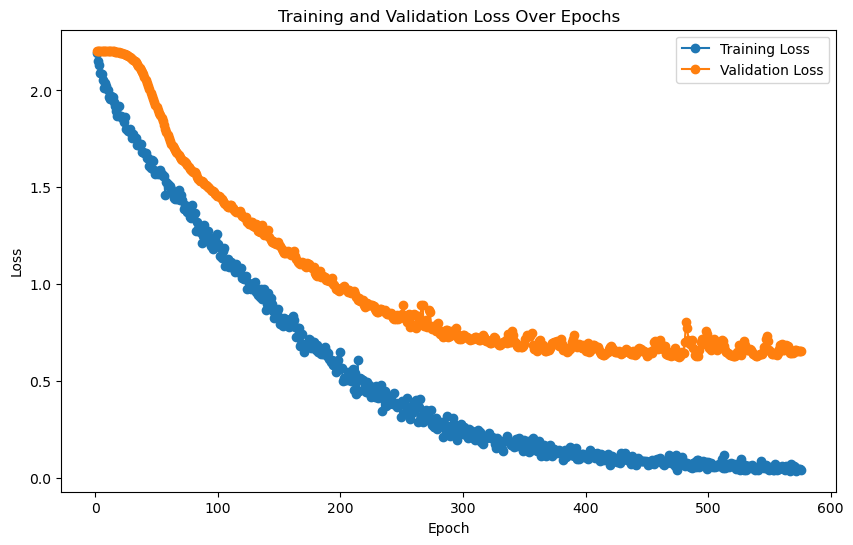

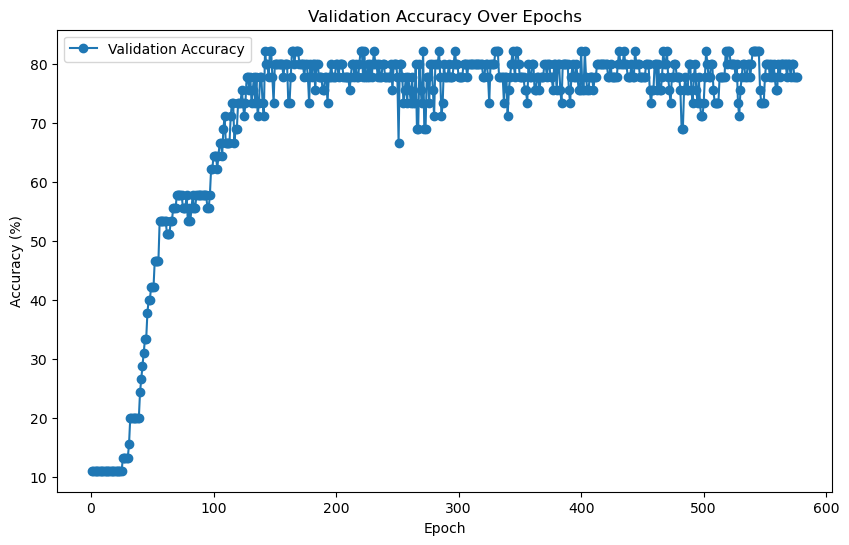


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.9158



Final Test Loss: 1.0657, Test Accuracy: 71.69%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42686, 64), Test labels shape: (42686,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 66.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.25      0.40      0.31         5
           2       0.67      0.80      0.73         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       0.50      0.40      0.44         5
           6       0.67      0.80      0.73         5
           7       0.67      0.40      0.50         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42686, 64)
Test labels shape: (42686,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1456  |  Val Loss: 2.0501
Validation loss improved from inf to 2.0501.
[Epoch 2/1000] Train Loss: 2.0426  |  Val Loss: 1.9750
Validation loss improved from 2.0501 to 1.9750.
[Epoch 3/1000] Train Loss: 1.9610  |  Val Loss: 1.9220
Validation loss improved from 1.9750 to 1.9220.
[Epoch 4/1000] Train Loss: 1.8995  |  Val Loss: 1.8760
Validation loss improved from 1.9220 to 1.8760.
[Epoch 5/1000] Train Loss: 1.8482  |  Val Loss: 1.8322
Validation loss improved from 1.8760 to 1.8322.
[Epoch 6/1000] Train Loss: 1.7984  |  Val Loss: 1.7937
Validation loss improved from 1.8322 to 1.7937.
[Epoch 7/1000] Train Loss: 1.7529  |  Val Loss: 1.7599
Validation loss improved from 1.7937 to 1.7599.
[Epoch 8/1000] Train Loss: 1.7114  |  Val Loss: 1.7271
Validation loss improved from 1.7599 to 1.7271.
[Epoch 9/1000] Train Loss: 1.6718  |  Val Loss: 1.6939
Validation loss improved from 1.7271 to 1.6939.
[Epoch 10/1000] Train Loss: 1.6324  |  Val Loss: 1.6607
Validation loss impr

[Epoch 20/1000] Train Loss: 1.2713  |  Val Loss: 1.3363
Validation loss improved from 1.3624 to 1.3363.
[Epoch 21/1000] Train Loss: 1.2406  |  Val Loss: 1.3117
Validation loss improved from 1.3363 to 1.3117.
[Epoch 22/1000] Train Loss: 1.2107  |  Val Loss: 1.2880
Validation loss improved from 1.3117 to 1.2880.
[Epoch 23/1000] Train Loss: 1.1811  |  Val Loss: 1.2658
Validation loss improved from 1.2880 to 1.2658.
[Epoch 24/1000] Train Loss: 1.1520  |  Val Loss: 1.2444
Validation loss improved from 1.2658 to 1.2444.
[Epoch 25/1000] Train Loss: 1.1229  |  Val Loss: 1.2241
Validation loss improved from 1.2444 to 1.2241.
[Epoch 26/1000] Train Loss: 1.0937  |  Val Loss: 1.2038
Validation loss improved from 1.2241 to 1.2038.
[Epoch 27/1000] Train Loss: 1.0642  |  Val Loss: 1.1843
Validation loss improved from 1.2038 to 1.1843.
[Epoch 28/1000] Train Loss: 1.0350  |  Val Loss: 1.1645
Validation loss improved from 1.1843 to 1.1645.
[Epoch 29/1000] Train Loss: 1.0064  |  Val Loss: 1.1454
Validati

[Epoch 55/1000] Train Loss: 0.4820  |  Val Loss: 0.8363
Validation loss improved from 0.8379 to 0.8363.
[Epoch 56/1000] Train Loss: 0.4701  |  Val Loss: 0.8366
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.4587  |  Val Loss: 0.8375
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.4475  |  Val Loss: 0.8382
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.4368  |  Val Loss: 0.8385
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.4265  |  Val Loss: 0.8378
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 0.4166  |  Val Loss: 0.8374
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 0.4072  |  Val Loss: 0.8386
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 63/1000] Train Loss: 0.3979  |  Val Loss: 0.8404
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 64/1000] 

[Epoch 72/1000] Train Loss: 0.3240  |  Val Loss: 0.8538
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 73/1000] Train Loss: 0.3165  |  Val Loss: 0.8577
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 74/1000] Train Loss: 0.3094  |  Val Loss: 0.8633
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 75/1000] Train Loss: 0.3024  |  Val Loss: 0.8697
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 76/1000] Train Loss: 0.2957  |  Val Loss: 0.8754
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 77/1000] Train Loss: 0.2890  |  Val Loss: 0.8797
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 78/1000] Train Loss: 0.2823  |  Val Loss: 0.8839
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 79/1000] Train Loss: 0.2761  |  Val Loss: 0.8879
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 80/1000] Train Loss: 0.2698  |  Val Loss: 0.8921
!! Validation loss did NOT improve !! Patience: 25/100
[

[Epoch 97/1000] Train Loss: 0.1754  |  Val Loss: 1.0187
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 98/1000] Train Loss: 0.1708  |  Val Loss: 1.0263
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 99/1000] Train Loss: 0.1661  |  Val Loss: 1.0337
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 100/1000] Train Loss: 0.1617  |  Val Loss: 1.0420
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 101/1000] Train Loss: 0.1575  |  Val Loss: 1.0508
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 102/1000] Train Loss: 0.1533  |  Val Loss: 1.0599
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 103/1000] Train Loss: 0.1492  |  Val Loss: 1.0688
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 104/1000] Train Loss: 0.1452  |  Val Loss: 1.0774
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 105/1000] Train Loss: 0.1414  |  Val Loss: 1.0848
!! Validation loss did NOT improve !! Patience: 50

[Epoch 131/1000] Train Loss: 0.0713  |  Val Loss: 1.2855
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 132/1000] Train Loss: 0.0696  |  Val Loss: 1.2922
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 133/1000] Train Loss: 0.0678  |  Val Loss: 1.2985
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 134/1000] Train Loss: 0.0660  |  Val Loss: 1.3045
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 135/1000] Train Loss: 0.0643  |  Val Loss: 1.3104
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 136/1000] Train Loss: 0.0627  |  Val Loss: 1.3169
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 137/1000] Train Loss: 0.0611  |  Val Loss: 1.3242
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 138/1000] Train Loss: 0.0595  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 139/1000] Train Loss: 0.0580  |  Val Loss: 1.3406
!! Validation loss did NOT improve !! Patience:

[Epoch 145/1000] Train Loss: 0.0496  |  Val Loss: 1.3789
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 146/1000] Train Loss: 0.0483  |  Val Loss: 1.3841
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 147/1000] Train Loss: 0.0470  |  Val Loss: 1.3902
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 148/1000] Train Loss: 0.0458  |  Val Loss: 1.3967
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 149/1000] Train Loss: 0.0446  |  Val Loss: 1.4051
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 150/1000] Train Loss: 0.0435  |  Val Loss: 1.4144
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 151/1000] Train Loss: 0.0424  |  Val Loss: 1.4239
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 152/1000] Train Loss: 0.0413  |  Val Loss: 1.4325
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 153/1000] Train Loss: 0.0402  |  Val Loss: 1.4391
!! Validation loss did NOT improve !! Patience:

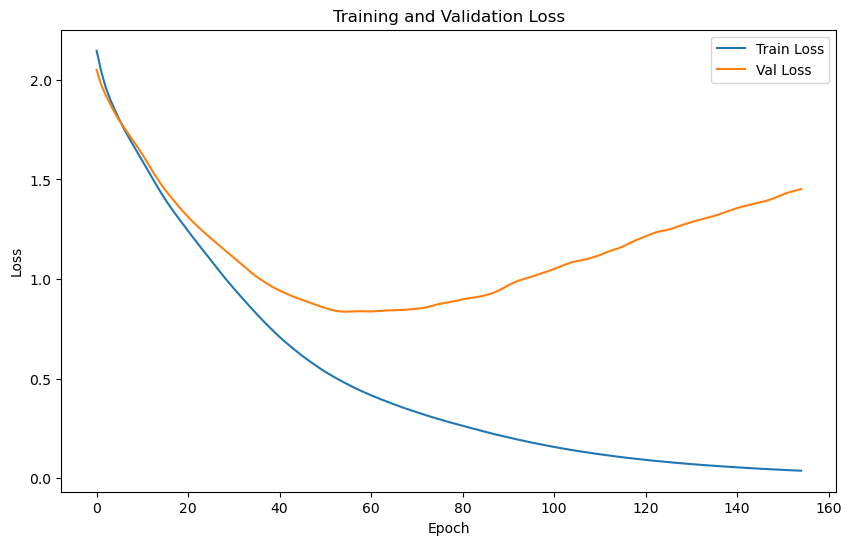

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.1190 | Test Accuracy: 60.00%


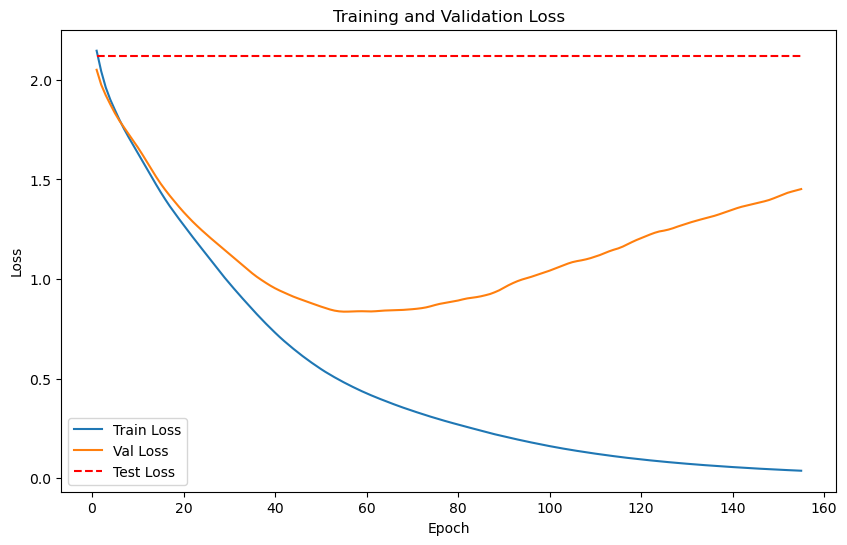

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.3674
Epoch [1/2000], Avg Train Loss: 8.3674
Epoch [1/2000], Avg Val Loss: 4.5915
Validation loss improved from inf to 4.5915. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1669
Epoch [2/2000], Avg Train Loss: 8.1669
Epoch [2/2000], Avg Val Loss: 4.5542
Validation loss improved from 4.5915 to 4.5542. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4325
Epoch [3/2000], Avg Train Loss: 8.4325
Epoch [3/2000], Avg Val Loss: 4.5177
Validation loss improved from 4.5542 to 4.5177. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.5303
Epoch [4/2000], Avg Train Loss: 8.5303
Epoch [4/2000], Avg Val Loss: 4.4826
Validation loss improved from 4.5177 to 4.4826. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.0840
Epoch [5/2000], Avg Train Loss: 8.0840
Epoch [5/2000], Avg Val Loss: 4.4482
Validation loss improved fr

    Batch [1/1], Train Loss: 8.1261
Epoch [9/2000], Avg Train Loss: 8.1261
Epoch [9/2000], Avg Val Loss: 4.3175
Validation loss improved from 4.3492 to 4.3175. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.5431
Epoch [10/2000], Avg Train Loss: 7.5431
Epoch [10/2000], Avg Val Loss: 4.2868
Validation loss improved from 4.3175 to 4.2868. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.6551
Epoch [11/2000], Avg Train Loss: 7.6551
Epoch [11/2000], Avg Val Loss: 4.2569
Validation loss improved from 4.2868 to 4.2569. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.6660
Epoch [12/2000], Avg Train Loss: 7.6660
Epoch [12/2000], Avg Val Loss: 4.2277
Validation loss improved from 4.2569 to 4.2277. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.0046
Epoch [13/2000], Avg Train Loss: 8.0046
Epoch [13/2000], Avg Val Loss: 4.1988
Validation loss improved from 4.2277 to 4.19

    Batch [1/1], Train Loss: 6.5333
Epoch [27/2000], Avg Train Loss: 6.5333
Epoch [27/2000], Avg Val Loss: 3.8524
Validation loss improved from 3.8736 to 3.8524. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.8514
Epoch [28/2000], Avg Train Loss: 6.8514
Epoch [28/2000], Avg Val Loss: 3.8317
Validation loss improved from 3.8524 to 3.8317. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.7373
Epoch [29/2000], Avg Train Loss: 6.7373
Epoch [29/2000], Avg Val Loss: 3.8113
Validation loss improved from 3.8317 to 3.8113. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.7206
Epoch [30/2000], Avg Train Loss: 6.7206
Epoch [30/2000], Avg Val Loss: 3.7916
Validation loss improved from 3.8113 to 3.7916. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.3689
Epoch [31/2000], Avg Train Loss: 6.3689
Epoch [31/2000], Avg Val Loss: 3.7724
Validation loss improved from 3.7916 to 3.

    Batch [1/1], Train Loss: 4.9340
Epoch [58/2000], Avg Train Loss: 4.9340
Epoch [58/2000], Avg Val Loss: 3.4134
Validation loss improved from 3.4225 to 3.4134. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.1572
Epoch [59/2000], Avg Train Loss: 5.1572
Epoch [59/2000], Avg Val Loss: 3.4046
Validation loss improved from 3.4134 to 3.4046. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.0775
Epoch [60/2000], Avg Train Loss: 5.0775
Epoch [60/2000], Avg Val Loss: 3.3959
Validation loss improved from 3.4046 to 3.3959. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5709
Epoch [61/2000], Avg Train Loss: 5.5709
Epoch [61/2000], Avg Val Loss: 3.3874
Validation loss improved from 3.3959 to 3.3874. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.4142
Epoch [62/2000], Avg Train Loss: 5.4142
Epoch [62/2000], Avg Val Loss: 3.3791
Validation loss improved from 3.3874 to 3.

    Batch [1/1], Train Loss: 4.7892
Epoch [75/2000], Avg Train Loss: 4.7892
Epoch [75/2000], Avg Val Loss: 3.2913
Validation loss improved from 3.2970 to 3.2913. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.8343
Epoch [76/2000], Avg Train Loss: 4.8343
Epoch [76/2000], Avg Val Loss: 3.2857
Validation loss improved from 3.2913 to 3.2857. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 4.7591
Epoch [77/2000], Avg Train Loss: 4.7591
Epoch [77/2000], Avg Val Loss: 3.2802
Validation loss improved from 3.2857 to 3.2802. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.6271
Epoch [78/2000], Avg Train Loss: 4.6271
Epoch [78/2000], Avg Val Loss: 3.2749
Validation loss improved from 3.2802 to 3.2749. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.6912
Epoch [79/2000], Avg Train Loss: 4.6912
Epoch [79/2000], Avg Val Loss: 3.2697
Validation loss improved from 3.2749 to 3.

    Batch [1/1], Train Loss: 4.1630
Epoch [107/2000], Avg Train Loss: 4.1630
Epoch [107/2000], Avg Val Loss: 3.1655
Validation loss improved from 3.1682 to 3.1655. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.1335
Epoch [108/2000], Avg Train Loss: 4.1335
Epoch [108/2000], Avg Val Loss: 3.1629
Validation loss improved from 3.1655 to 3.1629. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.0878
Epoch [109/2000], Avg Train Loss: 4.0878
Epoch [109/2000], Avg Val Loss: 3.1603
Validation loss improved from 3.1629 to 3.1603. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.1487
Epoch [110/2000], Avg Train Loss: 4.1487
Epoch [110/2000], Avg Val Loss: 3.1578
Validation loss improved from 3.1603 to 3.1578. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 3.9264
Epoch [111/2000], Avg Train Loss: 3.9264
Epoch [111/2000], Avg Val Loss: 3.1553
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8005
Epoch [130/2000], Avg Train Loss: 3.8005
Epoch [130/2000], Avg Val Loss: 3.1178
Validation loss improved from 3.1195 to 3.1178. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 3.8308
Epoch [131/2000], Avg Train Loss: 3.8308
Epoch [131/2000], Avg Val Loss: 3.1163
Validation loss improved from 3.1178 to 3.1163. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 3.8915
Epoch [132/2000], Avg Train Loss: 3.8915
Epoch [132/2000], Avg Val Loss: 3.1147
Validation loss improved from 3.1163 to 3.1147. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.0372
Epoch [133/2000], Avg Train Loss: 4.0372
Epoch [133/2000], Avg Val Loss: 3.1131
Validation loss improved from 3.1147 to 3.1131. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 3.8983
Epoch [134/2000], Avg Train Loss: 3.8983
Epoch [134/2000], Avg Val Loss: 3.1116
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7795
Epoch [158/2000], Avg Train Loss: 3.7795
Epoch [158/2000], Avg Val Loss: 3.0790
Validation loss improved from 3.0801 to 3.0790. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 3.6401
Epoch [159/2000], Avg Train Loss: 3.6401
Epoch [159/2000], Avg Val Loss: 3.0779
Validation loss improved from 3.0790 to 3.0779. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.5821
Epoch [160/2000], Avg Train Loss: 3.5821
Epoch [160/2000], Avg Val Loss: 3.0769
Validation loss improved from 3.0779 to 3.0769. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.6075
Epoch [161/2000], Avg Train Loss: 3.6075
Epoch [161/2000], Avg Val Loss: 3.0758
Validation loss improved from 3.0769 to 3.0758. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 3.5043
Epoch [162/2000], Avg Train Loss: 3.5043
Epoch [162/2000], Avg Val Loss: 3.0748
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4877
Epoch [179/2000], Avg Train Loss: 3.4877
Epoch [179/2000], Avg Val Loss: 3.0590
Validation loss improved from 3.0599 to 3.0590. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 3.5663
Epoch [180/2000], Avg Train Loss: 3.5663
Epoch [180/2000], Avg Val Loss: 3.0581
Validation loss improved from 3.0590 to 3.0581. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 3.5244
Epoch [181/2000], Avg Train Loss: 3.5244
Epoch [181/2000], Avg Val Loss: 3.0573
Validation loss improved from 3.0581 to 3.0573. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 3.5835
Epoch [182/2000], Avg Train Loss: 3.5835
Epoch [182/2000], Avg Val Loss: 3.0564
Validation loss improved from 3.0573 to 3.0564. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 3.5638
Epoch [183/2000], Avg Train Loss: 3.5638
Epoch [183/2000], Avg Val Loss: 3.0556
Validation loss improved fro

Epoch [204/2000], Avg Val Loss: 3.0401
Validation loss improved from 3.0408 to 3.0401. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.2705
Epoch [205/2000], Avg Train Loss: 3.2705
Epoch [205/2000], Avg Val Loss: 3.0395
Validation loss improved from 3.0401 to 3.0395. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.3182
Epoch [206/2000], Avg Train Loss: 3.3182
Epoch [206/2000], Avg Val Loss: 3.0388
Validation loss improved from 3.0395 to 3.0388. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.3925
Epoch [207/2000], Avg Train Loss: 3.3925
Epoch [207/2000], Avg Val Loss: 3.0382
Validation loss improved from 3.0388 to 3.0382. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.3522
Epoch [208/2000], Avg Train Loss: 3.3522
Epoch [208/2000], Avg Val Loss: 3.0376
Validation loss improved from 3.0382 to 3.0376. Saving model...

LOG: Epoch [209/2000] - Training
    Bat

Epoch [229/2000], Avg Val Loss: 3.0250
Validation loss improved from 3.0256 to 3.0250. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.3614
Epoch [230/2000], Avg Train Loss: 3.3614
Epoch [230/2000], Avg Val Loss: 3.0244
Validation loss improved from 3.0250 to 3.0244. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.3306
Epoch [231/2000], Avg Train Loss: 3.3306
Epoch [231/2000], Avg Val Loss: 3.0238
Validation loss improved from 3.0244 to 3.0238. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.3053
Epoch [232/2000], Avg Train Loss: 3.3053
Epoch [232/2000], Avg Val Loss: 3.0233
Validation loss improved from 3.0238 to 3.0233. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.3128
Epoch [233/2000], Avg Train Loss: 3.3128
Epoch [233/2000], Avg Val Loss: 3.0227
Validation loss improved from 3.0233 to 3.0227. Saving model...

LOG: Epoch [234/2000] - Training
    Bat

Epoch [254/2000], Avg Val Loss: 3.0099
Validation loss improved from 3.0105 to 3.0099. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.2458
Epoch [255/2000], Avg Train Loss: 3.2458
Epoch [255/2000], Avg Val Loss: 3.0093
Validation loss improved from 3.0099 to 3.0093. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.2231
Epoch [256/2000], Avg Train Loss: 3.2231
Epoch [256/2000], Avg Val Loss: 3.0088
Validation loss improved from 3.0093 to 3.0088. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.2517
Epoch [257/2000], Avg Train Loss: 3.2517
Epoch [257/2000], Avg Val Loss: 3.0082
Validation loss improved from 3.0088 to 3.0082. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.2620
Epoch [258/2000], Avg Train Loss: 3.2620
Epoch [258/2000], Avg Val Loss: 3.0077
Validation loss improved from 3.0082 to 3.0077. Saving model...

LOG: Epoch [259/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4169
Epoch [281/2000], Avg Train Loss: 3.4169
Epoch [281/2000], Avg Val Loss: 2.9942
Validation loss improved from 2.9948 to 2.9942. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.2454
Epoch [282/2000], Avg Train Loss: 3.2454
Epoch [282/2000], Avg Val Loss: 2.9937
Validation loss improved from 2.9942 to 2.9937. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.2160
Epoch [283/2000], Avg Train Loss: 3.2160
Epoch [283/2000], Avg Val Loss: 2.9932
Validation loss improved from 2.9937 to 2.9932. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.2062
Epoch [284/2000], Avg Train Loss: 3.2062
Epoch [284/2000], Avg Val Loss: 2.9927
Validation loss improved from 2.9932 to 2.9927. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.1105
Epoch [285/2000], Avg Train Loss: 3.1105
Epoch [285/2000], Avg Val Loss: 2.9922
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1481
Epoch [303/2000], Avg Train Loss: 3.1481
Epoch [303/2000], Avg Val Loss: 2.9832
Validation loss improved from 2.9837 to 2.9832. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.1448
Epoch [304/2000], Avg Train Loss: 3.1448
Epoch [304/2000], Avg Val Loss: 2.9827
Validation loss improved from 2.9832 to 2.9827. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.1675
Epoch [305/2000], Avg Train Loss: 3.1675
Epoch [305/2000], Avg Val Loss: 2.9822
Validation loss improved from 2.9827 to 2.9822. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.1933
Epoch [306/2000], Avg Train Loss: 3.1933
Epoch [306/2000], Avg Val Loss: 2.9816
Validation loss improved from 2.9822 to 2.9816. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.0894
Epoch [307/2000], Avg Train Loss: 3.0894
Epoch [307/2000], Avg Val Loss: 2.9811
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1778
Epoch [325/2000], Avg Train Loss: 3.1778
Epoch [325/2000], Avg Val Loss: 2.9710
Validation loss improved from 2.9716 to 2.9710. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.2166
Epoch [326/2000], Avg Train Loss: 3.2166
Epoch [326/2000], Avg Val Loss: 2.9705
Validation loss improved from 2.9710 to 2.9705. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.1129
Epoch [327/2000], Avg Train Loss: 3.1129
Epoch [327/2000], Avg Val Loss: 2.9700
Validation loss improved from 2.9705 to 2.9700. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.1120
Epoch [328/2000], Avg Train Loss: 3.1120
Epoch [328/2000], Avg Val Loss: 2.9695
Validation loss improved from 2.9700 to 2.9695. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.2253
Epoch [329/2000], Avg Train Loss: 3.2253
Epoch [329/2000], Avg Val Loss: 2.9690
Validation loss improved fro

Epoch [351/2000], Avg Val Loss: 2.9575
Validation loss improved from 2.9581 to 2.9575. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 3.0034
Epoch [352/2000], Avg Train Loss: 3.0034
Epoch [352/2000], Avg Val Loss: 2.9570
Validation loss improved from 2.9575 to 2.9570. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.0033
Epoch [353/2000], Avg Train Loss: 3.0033
Epoch [353/2000], Avg Val Loss: 2.9564
Validation loss improved from 2.9570 to 2.9564. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 3.0981
Epoch [354/2000], Avg Train Loss: 3.0981
Epoch [354/2000], Avg Val Loss: 2.9558
Validation loss improved from 2.9564 to 2.9558. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.0882
Epoch [355/2000], Avg Train Loss: 3.0882
Epoch [355/2000], Avg Val Loss: 2.9552
Validation loss improved from 2.9558 to 2.9552. Saving model...

LOG: Epoch [356/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9271
Epoch [376/2000], Avg Train Loss: 2.9271
Epoch [376/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9451 to 2.9445. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 3.0562
Epoch [377/2000], Avg Train Loss: 3.0562
Epoch [377/2000], Avg Val Loss: 2.9440
Validation loss improved from 2.9445 to 2.9440. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 3.0061
Epoch [378/2000], Avg Train Loss: 3.0061
Epoch [378/2000], Avg Val Loss: 2.9434
Validation loss improved from 2.9440 to 2.9434. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 2.9481
Epoch [379/2000], Avg Train Loss: 2.9481
Epoch [379/2000], Avg Val Loss: 2.9429
Validation loss improved from 2.9434 to 2.9429. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 2.9396
Epoch [380/2000], Avg Train Loss: 2.9396
Epoch [380/2000], Avg Val Loss: 2.9423
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9728
Epoch [404/2000], Avg Train Loss: 2.9728
Epoch [404/2000], Avg Val Loss: 2.9287
Validation loss improved from 2.9293 to 2.9287. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 2.9604
Epoch [405/2000], Avg Train Loss: 2.9604
Epoch [405/2000], Avg Val Loss: 2.9281
Validation loss improved from 2.9287 to 2.9281. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 2.9107
Epoch [406/2000], Avg Train Loss: 2.9107
Epoch [406/2000], Avg Val Loss: 2.9275
Validation loss improved from 2.9281 to 2.9275. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.0088
Epoch [407/2000], Avg Train Loss: 3.0088
Epoch [407/2000], Avg Val Loss: 2.9270
Validation loss improved from 2.9275 to 2.9270. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 2.9440
Epoch [408/2000], Avg Train Loss: 2.9440
Epoch [408/2000], Avg Val Loss: 2.9264
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8393
Epoch [420/2000], Avg Train Loss: 2.8393
Epoch [420/2000], Avg Val Loss: 2.9201
Validation loss improved from 2.9206 to 2.9201. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 2.9188
Epoch [421/2000], Avg Train Loss: 2.9188
Epoch [421/2000], Avg Val Loss: 2.9196
Validation loss improved from 2.9201 to 2.9196. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 2.8792
Epoch [422/2000], Avg Train Loss: 2.8792
Epoch [422/2000], Avg Val Loss: 2.9191
Validation loss improved from 2.9196 to 2.9191. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.0064
Epoch [423/2000], Avg Train Loss: 3.0064
Epoch [423/2000], Avg Val Loss: 2.9186
Validation loss improved from 2.9191 to 2.9186. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 2.9557
Epoch [424/2000], Avg Train Loss: 2.9557
Epoch [424/2000], Avg Val Loss: 2.9181
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8953
Epoch [454/2000], Avg Train Loss: 2.8953
Epoch [454/2000], Avg Val Loss: 2.9041
Validation loss improved from 2.9045 to 2.9041. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 2.8708
Epoch [455/2000], Avg Train Loss: 2.8708
Epoch [455/2000], Avg Val Loss: 2.9036
Validation loss improved from 2.9041 to 2.9036. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 2.9061
Epoch [456/2000], Avg Train Loss: 2.9061
Epoch [456/2000], Avg Val Loss: 2.9032
Validation loss improved from 2.9036 to 2.9032. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 2.8920
Epoch [457/2000], Avg Train Loss: 2.8920
Epoch [457/2000], Avg Val Loss: 2.9028
Validation loss improved from 2.9032 to 2.9028. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 2.9098
Epoch [458/2000], Avg Train Loss: 2.9098
Epoch [458/2000], Avg Val Loss: 2.9024
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9742
Epoch [469/2000], Avg Train Loss: 2.9742
Epoch [469/2000], Avg Val Loss: 2.8978
Validation loss improved from 2.8982 to 2.8978. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 2.8995
Epoch [470/2000], Avg Train Loss: 2.8995
Epoch [470/2000], Avg Val Loss: 2.8975
Validation loss improved from 2.8978 to 2.8975. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 2.8070
Epoch [471/2000], Avg Train Loss: 2.8070
Epoch [471/2000], Avg Val Loss: 2.8971
Validation loss improved from 2.8975 to 2.8971. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 2.8012
Epoch [472/2000], Avg Train Loss: 2.8012
Epoch [472/2000], Avg Val Loss: 2.8967
Validation loss improved from 2.8971 to 2.8967. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 2.9089
Epoch [473/2000], Avg Train Loss: 2.9089
Epoch [473/2000], Avg Val Loss: 2.8963
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8911
Epoch [506/2000], Avg Train Loss: 2.8911
Epoch [506/2000], Avg Val Loss: 2.8835
Validation loss improved from 2.8838 to 2.8835. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 2.8795
Epoch [507/2000], Avg Train Loss: 2.8795
Epoch [507/2000], Avg Val Loss: 2.8831
Validation loss improved from 2.8835 to 2.8831. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 2.8642
Epoch [508/2000], Avg Train Loss: 2.8642
Epoch [508/2000], Avg Val Loss: 2.8827
Validation loss improved from 2.8831 to 2.8827. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 2.9445
Epoch [509/2000], Avg Train Loss: 2.9445
Epoch [509/2000], Avg Val Loss: 2.8824
Validation loss improved from 2.8827 to 2.8824. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 2.8635
Epoch [510/2000], Avg Train Loss: 2.8635
Epoch [510/2000], Avg Val Loss: 2.8820
Validation loss improved fro

Epoch [516/2000], Avg Val Loss: 2.8797
Validation loss improved from 2.8801 to 2.8797. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 2.7657
Epoch [517/2000], Avg Train Loss: 2.7657
Epoch [517/2000], Avg Val Loss: 2.8793
Validation loss improved from 2.8797 to 2.8793. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 2.8284
Epoch [518/2000], Avg Train Loss: 2.8284
Epoch [518/2000], Avg Val Loss: 2.8789
Validation loss improved from 2.8793 to 2.8789. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 2.7852
Epoch [519/2000], Avg Train Loss: 2.7852
Epoch [519/2000], Avg Val Loss: 2.8784
Validation loss improved from 2.8789 to 2.8784. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 2.8596
Epoch [520/2000], Avg Train Loss: 2.8596
Epoch [520/2000], Avg Val Loss: 2.8780
Validation loss improved from 2.8784 to 2.8780. Saving model...

LOG: Epoch [521/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7805
Epoch [560/2000], Avg Train Loss: 2.7805
Epoch [560/2000], Avg Val Loss: 2.8636
Validation loss improved from 2.8640 to 2.8636. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 2.7738
Epoch [561/2000], Avg Train Loss: 2.7738
Epoch [561/2000], Avg Val Loss: 2.8633
Validation loss improved from 2.8636 to 2.8633. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 2.7593
Epoch [562/2000], Avg Train Loss: 2.7593
Epoch [562/2000], Avg Val Loss: 2.8630
Validation loss improved from 2.8633 to 2.8630. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 2.7796
Epoch [563/2000], Avg Train Loss: 2.7796
Epoch [563/2000], Avg Val Loss: 2.8626
Validation loss improved from 2.8630 to 2.8626. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 2.7328
Epoch [564/2000], Avg Train Loss: 2.7328
Epoch [564/2000], Avg Val Loss: 2.8623
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7588
Epoch [568/2000], Avg Train Loss: 2.7588
Epoch [568/2000], Avg Val Loss: 2.8613
Validation loss improved from 2.8615 to 2.8613. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 2.7310
Epoch [569/2000], Avg Train Loss: 2.7310
Epoch [569/2000], Avg Val Loss: 2.8610
Validation loss improved from 2.8613 to 2.8610. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 2.7486
Epoch [570/2000], Avg Train Loss: 2.7486
Epoch [570/2000], Avg Val Loss: 2.8607
Validation loss improved from 2.8610 to 2.8607. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 2.7939
Epoch [571/2000], Avg Train Loss: 2.7939
Epoch [571/2000], Avg Val Loss: 2.8605
Validation loss improved from 2.8607 to 2.8605. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 2.7770
Epoch [572/2000], Avg Train Loss: 2.7770
Epoch [572/2000], Avg Val Loss: 2.8602
Validation loss improved fro

Epoch [609/2000], Avg Val Loss: 2.8479
Validation loss improved from 2.8482 to 2.8479. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 2.6919
Epoch [610/2000], Avg Train Loss: 2.6919
Epoch [610/2000], Avg Val Loss: 2.8475
Validation loss improved from 2.8479 to 2.8475. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 2.6720
Epoch [611/2000], Avg Train Loss: 2.6720
Epoch [611/2000], Avg Val Loss: 2.8472
Validation loss improved from 2.8475 to 2.8472. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 2.6551
Epoch [612/2000], Avg Train Loss: 2.6551
Epoch [612/2000], Avg Val Loss: 2.8468
Validation loss improved from 2.8472 to 2.8468. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 2.6959
Epoch [613/2000], Avg Train Loss: 2.6959
Epoch [613/2000], Avg Val Loss: 2.8464
Validation loss improved from 2.8468 to 2.8464. Saving model...

LOG: Epoch [614/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7003
Epoch [660/2000], Avg Train Loss: 2.7003
Epoch [660/2000], Avg Val Loss: 2.8366
Validation loss improved from 2.8367 to 2.8366. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 2.6625
Epoch [661/2000], Avg Train Loss: 2.6625
Epoch [661/2000], Avg Val Loss: 2.8364
Validation loss improved from 2.8366 to 2.8364. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 2.6594
Epoch [662/2000], Avg Train Loss: 2.6594
Epoch [662/2000], Avg Val Loss: 2.8362
Validation loss improved from 2.8364 to 2.8362. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 2.6956
Epoch [663/2000], Avg Train Loss: 2.6956
Epoch [663/2000], Avg Val Loss: 2.8361
Validation loss improved from 2.8362 to 2.8361. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 2.7560
Epoch [664/2000], Avg Train Loss: 2.7560
Epoch [664/2000], Avg Val Loss: 2.8359
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6135
Epoch [709/2000], Avg Train Loss: 2.6135
Epoch [709/2000], Avg Val Loss: 2.8293
Validation loss improved from 2.8294 to 2.8293. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 2.5856
Epoch [710/2000], Avg Train Loss: 2.5856
Epoch [710/2000], Avg Val Loss: 2.8292
Validation loss improved from 2.8293 to 2.8292. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 2.5883
Epoch [711/2000], Avg Train Loss: 2.5883
Epoch [711/2000], Avg Val Loss: 2.8292
Validation loss improved from 2.8292 to 2.8292. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 2.6609
Epoch [712/2000], Avg Train Loss: 2.6609
Epoch [712/2000], Avg Val Loss: 2.8291
Validation loss improved from 2.8292 to 2.8291. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 2.7311
Epoch [713/2000], Avg Train Loss: 2.7311
Epoch [713/2000], Avg Val Loss: 2.8290
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6247
Epoch [757/2000], Avg Train Loss: 2.6247
Epoch [757/2000], Avg Val Loss: 2.8267
Validation loss improved from 2.8268 to 2.8267. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 2.5820
Epoch [758/2000], Avg Train Loss: 2.5820
Epoch [758/2000], Avg Val Loss: 2.8266
Validation loss improved from 2.8267 to 2.8266. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 2.6944
Epoch [759/2000], Avg Train Loss: 2.6944
Epoch [759/2000], Avg Val Loss: 2.8264
Validation loss improved from 2.8266 to 2.8264. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 2.5511
Epoch [760/2000], Avg Train Loss: 2.5511
Epoch [760/2000], Avg Val Loss: 2.8264
Validation loss improved from 2.8264 to 2.8264. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 2.6223
Epoch [761/2000], Avg Train Loss: 2.6223
Epoch [761/2000], Avg Val Loss: 2.8263
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5573
Epoch [802/2000], Avg Train Loss: 2.5573
Epoch [802/2000], Avg Val Loss: 2.8228
Validation loss improved from 2.8229 to 2.8228. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 2.5210
Epoch [803/2000], Avg Train Loss: 2.5210
Epoch [803/2000], Avg Val Loss: 2.8227
Validation loss improved from 2.8228 to 2.8227. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 2.5636
Epoch [804/2000], Avg Train Loss: 2.5636
Epoch [804/2000], Avg Val Loss: 2.8226
Validation loss improved from 2.8227 to 2.8226. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 2.4349
Epoch [805/2000], Avg Train Loss: 2.4349
Epoch [805/2000], Avg Val Loss: 2.8225
Validation loss improved from 2.8226 to 2.8225. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 2.5248
Epoch [806/2000], Avg Train Loss: 2.5248
Epoch [806/2000], Avg Val Loss: 2.8224
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4658
Epoch [851/2000], Avg Train Loss: 2.4658
Epoch [851/2000], Avg Val Loss: 2.8224
Validation loss did not improve. Patience: 36/100

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.5361
Epoch [852/2000], Avg Train Loss: 2.5361
Epoch [852/2000], Avg Val Loss: 2.8224
Validation loss did not improve. Patience: 37/100

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.5105
Epoch [853/2000], Avg Train Loss: 2.5105
Epoch [853/2000], Avg Val Loss: 2.8224
Validation loss did not improve. Patience: 38/100

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 2.5501
Epoch [854/2000], Avg Train Loss: 2.5501
Epoch [854/2000], Avg Val Loss: 2.8225
Validation loss did not improve. Patience: 39/100

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 2.5071
Epoch [855/2000], Avg Train Loss: 2.5071
Epoch [855/2000], Avg Val Loss: 2.8225
Validation loss did not improve. Patience: 40/100

LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 2.5201
Epoch [901/2000], Avg Train Loss: 2.5201
Epoch [901/2000], Avg Val Loss: 2.8225
Validation loss did not improve. Patience: 86/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 2.4568
Epoch [902/2000], Avg Train Loss: 2.4568
Epoch [902/2000], Avg Val Loss: 2.8224
Validation loss did not improve. Patience: 87/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 2.4463
Epoch [903/2000], Avg Train Loss: 2.4463
Epoch [903/2000], Avg Val Loss: 2.8224
Validation loss did not improve. Patience: 88/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 2.5010
Epoch [904/2000], Avg Train Loss: 2.5010
Epoch [904/2000], Avg Val Loss: 2.8225
Validation loss did not improve. Patience: 89/100

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 2.4835
Epoch [905/2000], Avg Train Loss: 2.4835
Epoch [905/2000], Avg Val Loss: 2.8225
Validation loss did not improve. Patience: 90/100

LOG: Epoch [906/2000] - Training


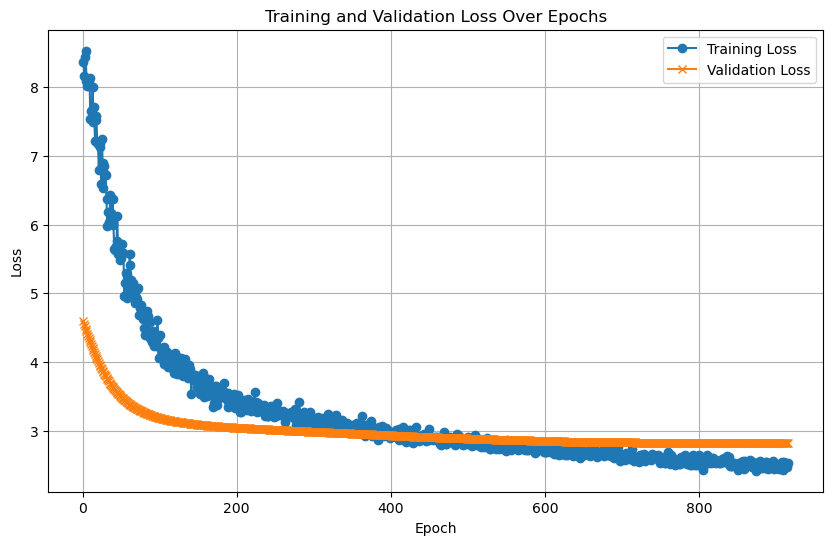

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.6159
Test Batch [20/167], Loss: 4.5701
Test Batch [30/167], Loss: 4.6068


Test Batch [40/167], Loss: 4.4028
Test Batch [50/167], Loss: 4.5538
Test Batch [60/167], Loss: 4.6233
Test Batch [70/167], Loss: 4.6050
Test Batch [80/167], Loss: 4.2592
Test Batch [90/167], Loss: 4.6110
Test Batch [100/167], Loss: 4.7589
Test Batch [110/167], Loss: 4.6146
Test Batch [120/167], Loss: 4.7311
Test Batch [130/167], Loss: 4.9915
Test Batch [140/167], Loss: 4.6978
Test Batch [150/167], Loss: 5.2073


Test Batch [160/167], Loss: 5.1239

Test Loss: 4.6762


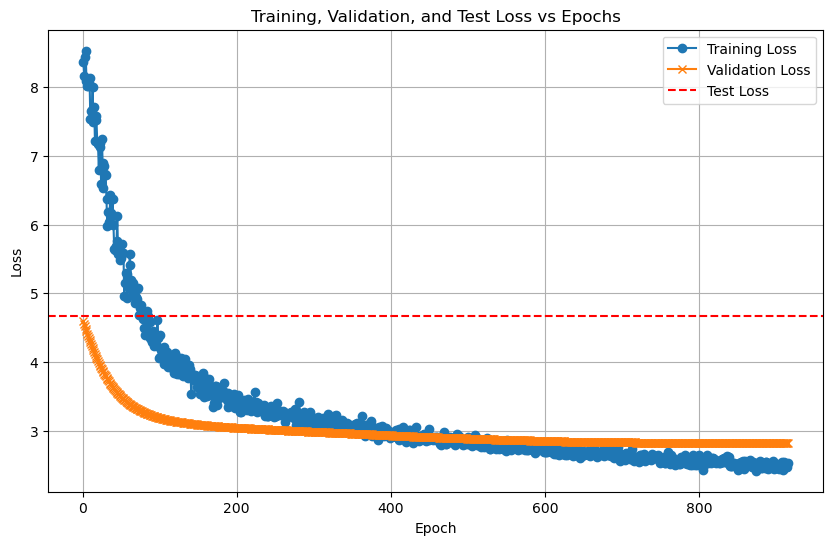

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.


  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.33      0.40      0.36         5
           2       0.40      0.40      0.40         5
           3       1.00      0.40      0.57         5
           4       1.00      0.80      0.89         5
           5       0.67      0.80      0.73         5
           6       0.71      1.00      0.83         5
           7       0.25      0.20      0.22         5
           8       1.00      1.00      1.00         5

    accuracy                           0.64        45
   macro avg       0.67      0.64      0.64        45
weighted avg       0.67      0.64      0.64        45


LOG: Evaluating on the test set...
Test Accuracy: 61.15%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4119  |  Val Loss: 2.3792
Validation loss improved from inf to 2.3792.


[Epoch 2/1000] Train Loss: 2.3971  |  Val Loss: 2.3668
Validation loss improved from 2.3792 to 2.3668.
[Epoch 3/1000] Train Loss: 2.3825  |  Val Loss: 2.3546
Validation loss improved from 2.3668 to 2.3546.
[Epoch 4/1000] Train Loss: 2.3684  |  Val Loss: 2.3429
Validation loss improved from 2.3546 to 2.3429.
[Epoch 5/1000] Train Loss: 2.3548  |  Val Loss: 2.3318
Validation loss improved from 2.3429 to 2.3318.
[Epoch 6/1000] Train Loss: 2.3417  |  Val Loss: 2.3212
Validation loss improved from 2.3318 to 2.3212.
[Epoch 7/1000] Train Loss: 2.3291  |  Val Loss: 2.3111
Validation loss improved from 2.3212 to 2.3111.
[Epoch 8/1000] Train Loss: 2.3169  |  Val Loss: 2.3013
Validation loss improved from 2.3111 to 2.3013.
[Epoch 9/1000] Train Loss: 2.3053  |  Val Loss: 2.2920
Validation loss improved from 2.3013 to 2.2920.
[Epoch 10/1000] Train Loss: 2.2938  |  Val Loss: 2.2831
Validation loss improved from 2.2920 to 2.2831.
[Epoch 11/1000] Train Loss: 2.2827  |  Val Loss: 2.2744
Validation loss 

[Epoch 18/1000] Train Loss: 2.2107  |  Val Loss: 2.2163
Validation loss improved from 2.2241 to 2.2163.
[Epoch 19/1000] Train Loss: 2.2012  |  Val Loss: 2.2086
Validation loss improved from 2.2163 to 2.2086.
[Epoch 20/1000] Train Loss: 2.1920  |  Val Loss: 2.2012
Validation loss improved from 2.2086 to 2.2012.
[Epoch 21/1000] Train Loss: 2.1830  |  Val Loss: 2.1939
Validation loss improved from 2.2012 to 2.1939.
[Epoch 22/1000] Train Loss: 2.1742  |  Val Loss: 2.1866
Validation loss improved from 2.1939 to 2.1866.
[Epoch 23/1000] Train Loss: 2.1656  |  Val Loss: 2.1796
Validation loss improved from 2.1866 to 2.1796.
[Epoch 24/1000] Train Loss: 2.1571  |  Val Loss: 2.1726
Validation loss improved from 2.1796 to 2.1726.
[Epoch 25/1000] Train Loss: 2.1487  |  Val Loss: 2.1656
Validation loss improved from 2.1726 to 2.1656.
[Epoch 26/1000] Train Loss: 2.1403  |  Val Loss: 2.1584
Validation loss improved from 2.1656 to 2.1584.
[Epoch 27/1000] Train Loss: 2.1319  |  Val Loss: 2.1512
Validati

[Epoch 66/1000] Train Loss: 1.8683  |  Val Loss: 1.9368
Validation loss improved from 1.9417 to 1.9368.
[Epoch 67/1000] Train Loss: 1.8623  |  Val Loss: 1.9319
Validation loss improved from 1.9368 to 1.9319.
[Epoch 68/1000] Train Loss: 1.8564  |  Val Loss: 1.9270
Validation loss improved from 1.9319 to 1.9270.
[Epoch 69/1000] Train Loss: 1.8507  |  Val Loss: 1.9221
Validation loss improved from 1.9270 to 1.9221.
[Epoch 70/1000] Train Loss: 1.8449  |  Val Loss: 1.9173
Validation loss improved from 1.9221 to 1.9173.
[Epoch 71/1000] Train Loss: 1.8392  |  Val Loss: 1.9125
Validation loss improved from 1.9173 to 1.9125.
[Epoch 72/1000] Train Loss: 1.8335  |  Val Loss: 1.9078
Validation loss improved from 1.9125 to 1.9078.
[Epoch 73/1000] Train Loss: 1.8277  |  Val Loss: 1.9031
Validation loss improved from 1.9078 to 1.9031.
[Epoch 74/1000] Train Loss: 1.8219  |  Val Loss: 1.8985
Validation loss improved from 1.9031 to 1.8985.
[Epoch 75/1000] Train Loss: 1.8162  |  Val Loss: 1.8938
Validati

[Epoch 96/1000] Train Loss: 1.6992  |  Val Loss: 1.8005
Validation loss improved from 1.8050 to 1.8005.
[Epoch 97/1000] Train Loss: 1.6934  |  Val Loss: 1.7961
Validation loss improved from 1.8005 to 1.7961.
[Epoch 98/1000] Train Loss: 1.6876  |  Val Loss: 1.7916
Validation loss improved from 1.7961 to 1.7916.
[Epoch 99/1000] Train Loss: 1.6819  |  Val Loss: 1.7872
Validation loss improved from 1.7916 to 1.7872.
[Epoch 100/1000] Train Loss: 1.6762  |  Val Loss: 1.7829
Validation loss improved from 1.7872 to 1.7829.
[Epoch 101/1000] Train Loss: 1.6706  |  Val Loss: 1.7784
Validation loss improved from 1.7829 to 1.7784.
[Epoch 102/1000] Train Loss: 1.6650  |  Val Loss: 1.7739
Validation loss improved from 1.7784 to 1.7739.
[Epoch 103/1000] Train Loss: 1.6595  |  Val Loss: 1.7695
Validation loss improved from 1.7739 to 1.7695.
[Epoch 104/1000] Train Loss: 1.6539  |  Val Loss: 1.7650
Validation loss improved from 1.7695 to 1.7650.
[Epoch 105/1000] Train Loss: 1.6484  |  Val Loss: 1.7606
Va

[Epoch 143/1000] Train Loss: 1.4614  |  Val Loss: 1.6125
Validation loss improved from 1.6160 to 1.6125.
[Epoch 144/1000] Train Loss: 1.4570  |  Val Loss: 1.6090
Validation loss improved from 1.6125 to 1.6090.
[Epoch 145/1000] Train Loss: 1.4527  |  Val Loss: 1.6055
Validation loss improved from 1.6090 to 1.6055.
[Epoch 146/1000] Train Loss: 1.4483  |  Val Loss: 1.6020
Validation loss improved from 1.6055 to 1.6020.
[Epoch 147/1000] Train Loss: 1.4441  |  Val Loss: 1.5985
Validation loss improved from 1.6020 to 1.5985.
[Epoch 148/1000] Train Loss: 1.4398  |  Val Loss: 1.5951
Validation loss improved from 1.5985 to 1.5951.
[Epoch 149/1000] Train Loss: 1.4355  |  Val Loss: 1.5916
Validation loss improved from 1.5951 to 1.5916.
[Epoch 150/1000] Train Loss: 1.4313  |  Val Loss: 1.5882
Validation loss improved from 1.5916 to 1.5882.
[Epoch 151/1000] Train Loss: 1.4271  |  Val Loss: 1.5848
Validation loss improved from 1.5882 to 1.5848.
[Epoch 152/1000] Train Loss: 1.4230  |  Val Loss: 1.581

[Epoch 167/1000] Train Loss: 1.3635  |  Val Loss: 1.5342
Validation loss improved from 1.5371 to 1.5342.
[Epoch 168/1000] Train Loss: 1.3597  |  Val Loss: 1.5313
Validation loss improved from 1.5342 to 1.5313.
[Epoch 169/1000] Train Loss: 1.3559  |  Val Loss: 1.5284
Validation loss improved from 1.5313 to 1.5284.
[Epoch 170/1000] Train Loss: 1.3522  |  Val Loss: 1.5255
Validation loss improved from 1.5284 to 1.5255.
[Epoch 171/1000] Train Loss: 1.3484  |  Val Loss: 1.5226
Validation loss improved from 1.5255 to 1.5226.
[Epoch 172/1000] Train Loss: 1.3447  |  Val Loss: 1.5197
Validation loss improved from 1.5226 to 1.5197.
[Epoch 173/1000] Train Loss: 1.3410  |  Val Loss: 1.5169
Validation loss improved from 1.5197 to 1.5169.
[Epoch 174/1000] Train Loss: 1.3373  |  Val Loss: 1.5140
Validation loss improved from 1.5169 to 1.5140.
[Epoch 175/1000] Train Loss: 1.3336  |  Val Loss: 1.5112
Validation loss improved from 1.5140 to 1.5112.
[Epoch 176/1000] Train Loss: 1.3300  |  Val Loss: 1.508

[Epoch 215/1000] Train Loss: 1.1980  |  Val Loss: 1.4095
Validation loss improved from 1.4120 to 1.4095.
[Epoch 216/1000] Train Loss: 1.1949  |  Val Loss: 1.4071
Validation loss improved from 1.4095 to 1.4071.
[Epoch 217/1000] Train Loss: 1.1917  |  Val Loss: 1.4047
Validation loss improved from 1.4071 to 1.4047.
[Epoch 218/1000] Train Loss: 1.1886  |  Val Loss: 1.4023
Validation loss improved from 1.4047 to 1.4023.
[Epoch 219/1000] Train Loss: 1.1855  |  Val Loss: 1.3999
Validation loss improved from 1.4023 to 1.3999.
[Epoch 220/1000] Train Loss: 1.1824  |  Val Loss: 1.3975
Validation loss improved from 1.3999 to 1.3975.
[Epoch 221/1000] Train Loss: 1.1793  |  Val Loss: 1.3951
Validation loss improved from 1.3975 to 1.3951.
[Epoch 222/1000] Train Loss: 1.1762  |  Val Loss: 1.3927
Validation loss improved from 1.3951 to 1.3927.
[Epoch 223/1000] Train Loss: 1.1731  |  Val Loss: 1.3903
Validation loss improved from 1.3927 to 1.3903.
[Epoch 224/1000] Train Loss: 1.1701  |  Val Loss: 1.387

[Epoch 241/1000] Train Loss: 1.1188  |  Val Loss: 1.3482
Validation loss improved from 1.3505 to 1.3482.
[Epoch 242/1000] Train Loss: 1.1158  |  Val Loss: 1.3460
Validation loss improved from 1.3482 to 1.3460.
[Epoch 243/1000] Train Loss: 1.1129  |  Val Loss: 1.3437
Validation loss improved from 1.3460 to 1.3437.
[Epoch 244/1000] Train Loss: 1.1100  |  Val Loss: 1.3415
Validation loss improved from 1.3437 to 1.3415.
[Epoch 245/1000] Train Loss: 1.1070  |  Val Loss: 1.3392
Validation loss improved from 1.3415 to 1.3392.
[Epoch 246/1000] Train Loss: 1.1041  |  Val Loss: 1.3369
Validation loss improved from 1.3392 to 1.3369.
[Epoch 247/1000] Train Loss: 1.1012  |  Val Loss: 1.3346
Validation loss improved from 1.3369 to 1.3346.
[Epoch 248/1000] Train Loss: 1.0983  |  Val Loss: 1.3324
Validation loss improved from 1.3346 to 1.3324.
[Epoch 249/1000] Train Loss: 1.0953  |  Val Loss: 1.3301
Validation loss improved from 1.3324 to 1.3301.
[Epoch 250/1000] Train Loss: 1.0924  |  Val Loss: 1.327

[Epoch 289/1000] Train Loss: 0.9820  |  Val Loss: 1.2414
Validation loss improved from 1.2436 to 1.2414.
[Epoch 290/1000] Train Loss: 0.9792  |  Val Loss: 1.2392
Validation loss improved from 1.2414 to 1.2392.
[Epoch 291/1000] Train Loss: 0.9763  |  Val Loss: 1.2371
Validation loss improved from 1.2392 to 1.2371.
[Epoch 292/1000] Train Loss: 0.9735  |  Val Loss: 1.2348
Validation loss improved from 1.2371 to 1.2348.
[Epoch 293/1000] Train Loss: 0.9707  |  Val Loss: 1.2327
Validation loss improved from 1.2348 to 1.2327.
[Epoch 294/1000] Train Loss: 0.9678  |  Val Loss: 1.2305
Validation loss improved from 1.2327 to 1.2305.
[Epoch 295/1000] Train Loss: 0.9650  |  Val Loss: 1.2283
Validation loss improved from 1.2305 to 1.2283.
[Epoch 296/1000] Train Loss: 0.9621  |  Val Loss: 1.2261
Validation loss improved from 1.2283 to 1.2261.
[Epoch 297/1000] Train Loss: 0.9593  |  Val Loss: 1.2240
Validation loss improved from 1.2261 to 1.2240.
[Epoch 298/1000] Train Loss: 0.9564  |  Val Loss: 1.221

[Epoch 308/1000] Train Loss: 0.9277  |  Val Loss: 1.1995
Validation loss improved from 1.2017 to 1.1995.
[Epoch 309/1000] Train Loss: 0.9248  |  Val Loss: 1.1972
Validation loss improved from 1.1995 to 1.1972.
[Epoch 310/1000] Train Loss: 0.9219  |  Val Loss: 1.1948
Validation loss improved from 1.1972 to 1.1948.
[Epoch 311/1000] Train Loss: 0.9190  |  Val Loss: 1.1925
Validation loss improved from 1.1948 to 1.1925.
[Epoch 312/1000] Train Loss: 0.9161  |  Val Loss: 1.1901
Validation loss improved from 1.1925 to 1.1901.
[Epoch 313/1000] Train Loss: 0.9132  |  Val Loss: 1.1878
Validation loss improved from 1.1901 to 1.1878.
[Epoch 314/1000] Train Loss: 0.9103  |  Val Loss: 1.1855
Validation loss improved from 1.1878 to 1.1855.
[Epoch 315/1000] Train Loss: 0.9074  |  Val Loss: 1.1832
Validation loss improved from 1.1855 to 1.1832.
[Epoch 316/1000] Train Loss: 0.9045  |  Val Loss: 1.1809
Validation loss improved from 1.1832 to 1.1809.
[Epoch 317/1000] Train Loss: 0.9016  |  Val Loss: 1.178

[Epoch 363/1000] Train Loss: 0.7680  |  Val Loss: 1.0787
Validation loss improved from 1.0808 to 1.0787.
[Epoch 364/1000] Train Loss: 0.7652  |  Val Loss: 1.0766
Validation loss improved from 1.0787 to 1.0766.
[Epoch 365/1000] Train Loss: 0.7623  |  Val Loss: 1.0745
Validation loss improved from 1.0766 to 1.0745.
[Epoch 366/1000] Train Loss: 0.7595  |  Val Loss: 1.0725
Validation loss improved from 1.0745 to 1.0725.
[Epoch 367/1000] Train Loss: 0.7566  |  Val Loss: 1.0705
Validation loss improved from 1.0725 to 1.0705.
[Epoch 368/1000] Train Loss: 0.7538  |  Val Loss: 1.0685
Validation loss improved from 1.0705 to 1.0685.
[Epoch 369/1000] Train Loss: 0.7509  |  Val Loss: 1.0666
Validation loss improved from 1.0685 to 1.0666.
[Epoch 370/1000] Train Loss: 0.7481  |  Val Loss: 1.0646
Validation loss improved from 1.0666 to 1.0646.
[Epoch 371/1000] Train Loss: 0.7453  |  Val Loss: 1.0627
Validation loss improved from 1.0646 to 1.0627.
[Epoch 372/1000] Train Loss: 0.7424  |  Val Loss: 1.060

[Epoch 387/1000] Train Loss: 0.7011  |  Val Loss: 1.0322
Validation loss improved from 1.0340 to 1.0322.
[Epoch 388/1000] Train Loss: 0.6984  |  Val Loss: 1.0304
Validation loss improved from 1.0322 to 1.0304.
[Epoch 389/1000] Train Loss: 0.6957  |  Val Loss: 1.0285
Validation loss improved from 1.0304 to 1.0285.
[Epoch 390/1000] Train Loss: 0.6930  |  Val Loss: 1.0266
Validation loss improved from 1.0285 to 1.0266.
[Epoch 391/1000] Train Loss: 0.6904  |  Val Loss: 1.0248
Validation loss improved from 1.0266 to 1.0248.
[Epoch 392/1000] Train Loss: 0.6877  |  Val Loss: 1.0229
Validation loss improved from 1.0248 to 1.0229.
[Epoch 393/1000] Train Loss: 0.6851  |  Val Loss: 1.0212
Validation loss improved from 1.0229 to 1.0212.
[Epoch 394/1000] Train Loss: 0.6824  |  Val Loss: 1.0193
Validation loss improved from 1.0212 to 1.0193.
[Epoch 395/1000] Train Loss: 0.6798  |  Val Loss: 1.0175
Validation loss improved from 1.0193 to 1.0175.
[Epoch 396/1000] Train Loss: 0.6772  |  Val Loss: 1.015

[Epoch 447/1000] Train Loss: 0.5532  |  Val Loss: 0.9390
Validation loss improved from 0.9401 to 0.9390.
[Epoch 448/1000] Train Loss: 0.5511  |  Val Loss: 0.9380
Validation loss improved from 0.9390 to 0.9380.
[Epoch 449/1000] Train Loss: 0.5490  |  Val Loss: 0.9370
Validation loss improved from 0.9380 to 0.9370.
[Epoch 450/1000] Train Loss: 0.5469  |  Val Loss: 0.9360
Validation loss improved from 0.9370 to 0.9360.
[Epoch 451/1000] Train Loss: 0.5449  |  Val Loss: 0.9350
Validation loss improved from 0.9360 to 0.9350.
[Epoch 452/1000] Train Loss: 0.5428  |  Val Loss: 0.9340
Validation loss improved from 0.9350 to 0.9340.
[Epoch 453/1000] Train Loss: 0.5408  |  Val Loss: 0.9330
Validation loss improved from 0.9340 to 0.9330.
[Epoch 454/1000] Train Loss: 0.5387  |  Val Loss: 0.9320
Validation loss improved from 0.9330 to 0.9320.
[Epoch 455/1000] Train Loss: 0.5367  |  Val Loss: 0.9310
Validation loss improved from 0.9320 to 0.9310.
[Epoch 456/1000] Train Loss: 0.5347  |  Val Loss: 0.930

[Epoch 466/1000] Train Loss: 0.5151  |  Val Loss: 0.9203
Validation loss improved from 0.9212 to 0.9203.
[Epoch 467/1000] Train Loss: 0.5132  |  Val Loss: 0.9194
Validation loss improved from 0.9203 to 0.9194.
[Epoch 468/1000] Train Loss: 0.5113  |  Val Loss: 0.9186
Validation loss improved from 0.9194 to 0.9186.
[Epoch 469/1000] Train Loss: 0.5094  |  Val Loss: 0.9178
Validation loss improved from 0.9186 to 0.9178.
[Epoch 470/1000] Train Loss: 0.5076  |  Val Loss: 0.9170
Validation loss improved from 0.9178 to 0.9170.
[Epoch 471/1000] Train Loss: 0.5057  |  Val Loss: 0.9162
Validation loss improved from 0.9170 to 0.9162.
[Epoch 472/1000] Train Loss: 0.5039  |  Val Loss: 0.9154
Validation loss improved from 0.9162 to 0.9154.
[Epoch 473/1000] Train Loss: 0.5020  |  Val Loss: 0.9146
Validation loss improved from 0.9154 to 0.9146.
[Epoch 474/1000] Train Loss: 0.5002  |  Val Loss: 0.9139
Validation loss improved from 0.9146 to 0.9139.
[Epoch 475/1000] Train Loss: 0.4984  |  Val Loss: 0.913

[Epoch 523/1000] Train Loss: 0.4219  |  Val Loss: 0.8880
Validation loss improved from 0.8883 to 0.8880.
[Epoch 524/1000] Train Loss: 0.4205  |  Val Loss: 0.8876
Validation loss improved from 0.8880 to 0.8876.
[Epoch 525/1000] Train Loss: 0.4191  |  Val Loss: 0.8873
Validation loss improved from 0.8876 to 0.8873.
[Epoch 526/1000] Train Loss: 0.4177  |  Val Loss: 0.8871
Validation loss improved from 0.8873 to 0.8871.
[Epoch 527/1000] Train Loss: 0.4163  |  Val Loss: 0.8869
Validation loss improved from 0.8871 to 0.8869.
[Epoch 528/1000] Train Loss: 0.4150  |  Val Loss: 0.8867
Validation loss improved from 0.8869 to 0.8867.
[Epoch 529/1000] Train Loss: 0.4136  |  Val Loss: 0.8864
Validation loss improved from 0.8867 to 0.8864.
[Epoch 530/1000] Train Loss: 0.4122  |  Val Loss: 0.8861
Validation loss improved from 0.8864 to 0.8861.
[Epoch 531/1000] Train Loss: 0.4109  |  Val Loss: 0.8858
Validation loss improved from 0.8861 to 0.8858.
[Epoch 532/1000] Train Loss: 0.4095  |  Val Loss: 0.885

[Epoch 546/1000] Train Loss: 0.3911  |  Val Loss: 0.8842
Validation loss improved from 0.8842 to 0.8842.
[Epoch 547/1000] Train Loss: 0.3899  |  Val Loss: 0.8841
Validation loss improved from 0.8842 to 0.8841.
[Epoch 548/1000] Train Loss: 0.3887  |  Val Loss: 0.8841
Validation loss improved from 0.8841 to 0.8841.
[Epoch 549/1000] Train Loss: 0.3875  |  Val Loss: 0.8840
Validation loss improved from 0.8841 to 0.8840.
[Epoch 550/1000] Train Loss: 0.3862  |  Val Loss: 0.8839
Validation loss improved from 0.8840 to 0.8839.
[Epoch 551/1000] Train Loss: 0.3850  |  Val Loss: 0.8838
Validation loss improved from 0.8839 to 0.8838.
[Epoch 552/1000] Train Loss: 0.3838  |  Val Loss: 0.8837
Validation loss improved from 0.8838 to 0.8837.
[Epoch 553/1000] Train Loss: 0.3826  |  Val Loss: 0.8836
Validation loss improved from 0.8837 to 0.8836.
[Epoch 554/1000] Train Loss: 0.3814  |  Val Loss: 0.8834
Validation loss improved from 0.8836 to 0.8834.
[Epoch 555/1000] Train Loss: 0.3802  |  Val Loss: 0.883

[Epoch 600/1000] Train Loss: 0.3321  |  Val Loss: 0.8881
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 601/1000] Train Loss: 0.3311  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 602/1000] Train Loss: 0.3302  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 603/1000] Train Loss: 0.3292  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 604/1000] Train Loss: 0.3283  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 605/1000] Train Loss: 0.3273  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 606/1000] Train Loss: 0.3264  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 607/1000] Train Loss: 0.3255  |  Val Loss: 0.8883
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 608/1000] Train Loss: 0.3245  |  Val Loss: 0.8883
!! Validation loss did NOT improve !! Patience:

[Epoch 621/1000] Train Loss: 0.3129  |  Val Loss: 0.8918
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 622/1000] Train Loss: 0.3120  |  Val Loss: 0.8921
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 623/1000] Train Loss: 0.3112  |  Val Loss: 0.8925
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 624/1000] Train Loss: 0.3103  |  Val Loss: 0.8929
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 625/1000] Train Loss: 0.3095  |  Val Loss: 0.8932
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 626/1000] Train Loss: 0.3086  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 627/1000] Train Loss: 0.3078  |  Val Loss: 0.8940
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 628/1000] Train Loss: 0.3069  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 629/1000] Train Loss: 0.3061  |  Val Loss: 0.8947
!! Validation loss did NOT improve !! Patience:

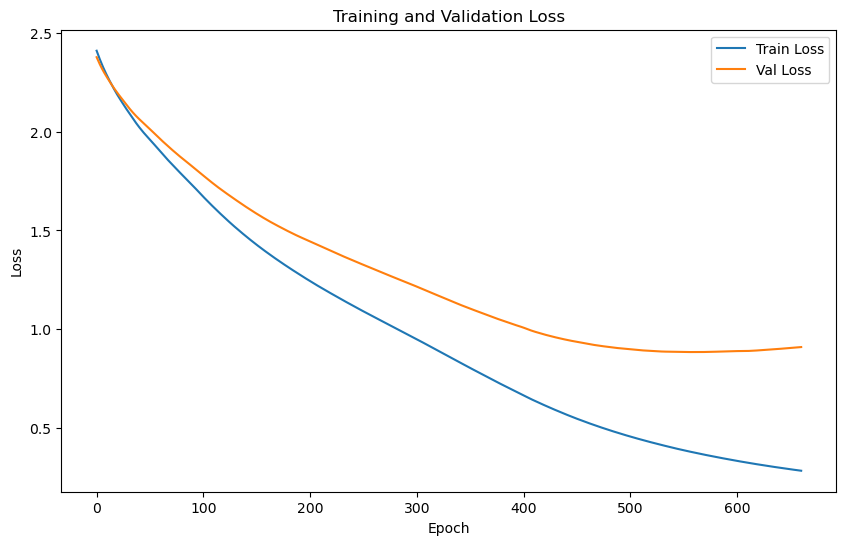

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.9353 | Test Accuracy: 65.90%


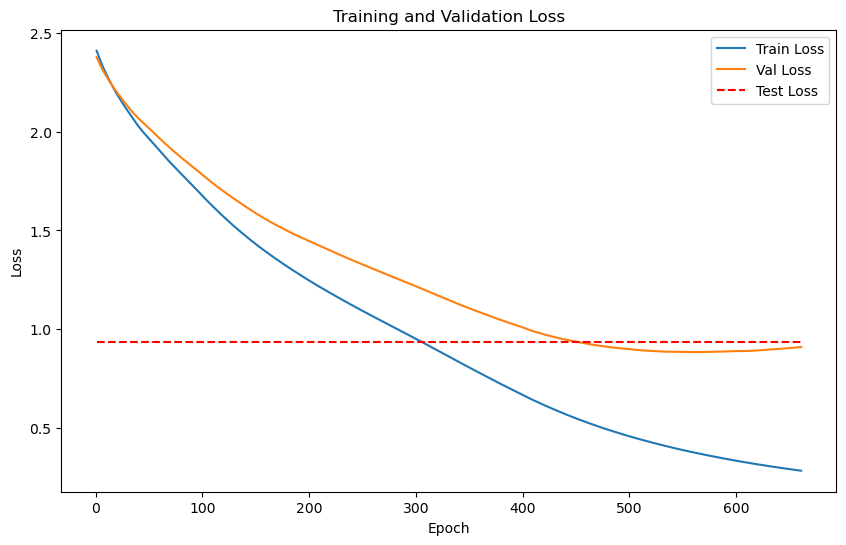

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [1/2000] - Validation


    Batch [1/1], Val Loss: 0.4531
Epoch [1/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4531

Validation loss improved from inf to 0.4531. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4516
Epoch [2/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4516

Validation loss improved from 0.4531 to 0.4516. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4495


Epoch [3/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4495

Validation loss improved from 0.4516 to 0.4495. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4466
Epoch [4/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4466

Validation loss improved from 0.4495 to 0.4466. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4434
Epoch [5/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4434

Validation loss improved from 0.4466 to 0.4434. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4404
Epoch [6/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4404

Validation loss improved from 0.4434 to 0.4404. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4376
Epoch [7/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4376

Validation loss improved from 0.4404 to 0.4376. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4360
Epoch [8/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4360

Validation loss improved from 0.4376 to 0.4360. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4350
Epoch [9/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4350

Validation loss improved from 0.4360 to 0.4350. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4338
Epoch [10/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4338

Validation loss improved from 0.4350 to 0.4338. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4327
Epoch [11/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4327

Validation loss improved from 0.4338 to 0.4327. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4318
Epoch [12/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4318

Validation loss improved from 0.4327 to 0.4318. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [13/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4311

Validation loss improved from 0.4318 to 0.4311. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4308
Epoch [14/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4308

Validation loss improved from 0.4311 to 0.4308. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.4308
Epoch [15/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4308

Validation loss improved from 0.4308 to 0.4308. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4309
Epoch [16/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4309

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [17/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4311

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4313
Epoch [18/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4313

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4314
Epoch [19/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4314

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.4314
Epoch [20/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4314

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4312
Epoch [21/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4312

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [22/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4311

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4310
Epoch [23/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4310

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4308
Epoch [24/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4308

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.4305
Epoch [25/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4305

Validation loss improved from 0.4308 to 0.4305. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4302
Epoch [26/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4302

Validation loss improved from 0.4305 to 0.4302. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.4299
Epoch [27/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4299

Validation loss improved from 0.4302 to 0.4299. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4296
Epoch [28/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4296

Validation loss improved from 0.4299 to 0.4296. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4293
Epoch [29/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4293

Validation loss improved from 0.4296 to 0.4293. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4290
Epoch [30/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4290

Validation loss improved from 0.4293 to 0.4290. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4287
Epoch [31/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4287

Validation loss improved from 0.4290 to 0.4287. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.4284
Epoch [32/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.4284

Validation loss improved from 0.4287 to 0.4284. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4281
Epoch [33/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4281

Validation loss improved from 0.4284 to 0.4281. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4278
Epoch [34/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4278

Validation loss improved from 0.4281 to 0.4278. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4275
Epoch [35/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4275

Validation loss improved from 0.4278 to 0.4275. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4272
Epoch [36/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.4272

Validation loss improved from 0.4275 to 0.4272. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4269
Epoch [37/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.4269

Validation loss improved from 0.4272 to 0.4269. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4266
Epoch [38/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.4266

Validation loss improved from 0.4269 to 0.4266. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4262
Epoch [39/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.4262

Validation loss improved from 0.4266 to 0.4262. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4259
Epoch [40/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.4259

Validation loss improved from 0.4262 to 0.4259. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4256
Epoch [41/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4256

Validation loss improved from 0.4259 to 0.4256. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4253
Epoch [42/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4253

Validation loss improved from 0.4256 to 0.4253. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4249
Epoch [43/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4249

Validation loss improved from 0.4253 to 0.4249. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.4246
Epoch [44/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4246

Validation loss improved from 0.4249 to 0.4246. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4242
Epoch [45/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4242

Validation loss improved from 0.4246 to 0.4242. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4239
Epoch [46/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4239

Validation loss improved from 0.4242 to 0.4239. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4235
Epoch [47/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4235

Validation loss improved from 0.4239 to 0.4235. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4232
Epoch [48/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.4232

Validation loss improved from 0.4235 to 0.4232. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4228
Epoch [49/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.4228

Validation loss improved from 0.4232 to 0.4228. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4225
Epoch [50/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.4225

Validation loss improved from 0.4228 to 0.4225. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4222
Epoch [51/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4222

Validation loss improved from 0.4225 to 0.4222. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4219
Epoch [52/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.4219

Validation loss improved from 0.4222 to 0.4219. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4215
Epoch [53/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.4215

Validation loss improved from 0.4219 to 0.4215. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [54/2000] - Validation


    Batch [1/1], Val Loss: 0.4212
Epoch [54/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.4212

Validation loss improved from 0.4215 to 0.4212. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4208
Epoch [55/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4208

Validation loss improved from 0.4212 to 0.4208. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.4205
Epoch [56/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4205

Validation loss improved from 0.4208 to 0.4205. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4201
Epoch [57/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4201

Validation loss improved from 0.4205 to 0.4201. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4197
Epoch [58/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.4197

Validation loss improved from 0.4201 to 0.4197. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4194
Epoch [59/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4194

Validation loss improved from 0.4197 to 0.4194. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [60/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.4191

Validation loss improved from 0.4194 to 0.4191. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.4187
Epoch [61/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4187

Validation loss improved from 0.4191 to 0.4187. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4184
Epoch [62/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4184

Validation loss improved from 0.4187 to 0.4184. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4180
Epoch [63/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.4180

Validation loss improved from 0.4184 to 0.4180. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4177
Epoch [64/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4177

Validation loss improved from 0.4180 to 0.4177. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4173
Epoch [65/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4173

Validation loss improved from 0.4177 to 0.4173. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.4170
Epoch [66/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.4170

Validation loss improved from 0.4173 to 0.4170. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4166
Epoch [67/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.4166

Validation loss improved from 0.4170 to 0.4166. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4163
Epoch [68/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.4163

Validation loss improved from 0.4166 to 0.4163. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.4160
Epoch [69/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.4160

Validation loss improved from 0.4163 to 0.4160. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4156
Epoch [70/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.4156

Validation loss improved from 0.4160 to 0.4156. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [71/2000] - Validation


    Batch [1/1], Val Loss: 0.4153
Epoch [71/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.4153

Validation loss improved from 0.4156 to 0.4153. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4149
Epoch [72/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.4149

Validation loss improved from 0.4153 to 0.4149. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4145
Epoch [73/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.4145

Validation loss improved from 0.4149 to 0.4145. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4141
Epoch [74/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.4141

Validation loss improved from 0.4145 to 0.4141. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4137
Epoch [75/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.4137

Validation loss improved from 0.4141 to 0.4137. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.4133
Epoch [76/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.4133

Validation loss improved from 0.4137 to 0.4133. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4130
Epoch [77/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.4130

Validation loss improved from 0.4133 to 0.4130. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.4126
Epoch [78/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.4126

Validation loss improved from 0.4130 to 0.4126. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4122
Epoch [79/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.4122

Validation loss improved from 0.4126 to 0.4122. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4119
Epoch [80/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.4119

Validation loss improved from 0.4122 to 0.4119. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.4115
Epoch [81/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.4115

Validation loss improved from 0.4119 to 0.4115. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4112
Epoch [82/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.4112

Validation loss improved from 0.4115 to 0.4112. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.4108
Epoch [83/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.4108

Validation loss improved from 0.4112 to 0.4108. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4104
Epoch [84/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.4104

Validation loss improved from 0.4108 to 0.4104. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.4101
Epoch [85/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.4101

Validation loss improved from 0.4104 to 0.4101. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [86/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.4097

Validation loss improved from 0.4101 to 0.4097. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.4094
Epoch [87/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.4094

Validation loss improved from 0.4097 to 0.4094. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.4090
Epoch [88/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.4090

Validation loss improved from 0.4094 to 0.4090. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [89/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.4087

Validation loss improved from 0.4090 to 0.4087. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.4084
Epoch [90/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.4084

Validation loss improved from 0.4087 to 0.4084. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [91/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.4081

Validation loss improved from 0.4084 to 0.4081. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.4078
Epoch [92/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.4078

Validation loss improved from 0.4081 to 0.4078. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.4076
Epoch [93/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.4076

Validation loss improved from 0.4078 to 0.4076. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.4073
Epoch [94/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.4073

Validation loss improved from 0.4076 to 0.4073. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.4070
Epoch [95/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.4070

Validation loss improved from 0.4073 to 0.4070. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [96/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.4066

Validation loss improved from 0.4070 to 0.4066. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [97/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.4064

Validation loss improved from 0.4066 to 0.4064. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [98/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.4061

Validation loss improved from 0.4064 to 0.4061. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [99/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.4059

Validation loss improved from 0.4061 to 0.4059. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.4056
Epoch [100/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.4056

Validation loss improved from 0.4059 to 0.4056. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.4054
Epoch [101/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.4054

Validation loss improved from 0.4056 to 0.4054. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.4051
Epoch [102/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.4051

Validation loss improved from 0.4054 to 0.4051. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [103/2000] - Validation


    Batch [1/1], Val Loss: 0.4048
Epoch [103/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.4048

Validation loss improved from 0.4051 to 0.4048. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [104/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.4045

Validation loss improved from 0.4048 to 0.4045. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.4043
Epoch [105/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.4043

Validation loss improved from 0.4045 to 0.4043. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [106/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.4041

Validation loss improved from 0.4043 to 0.4041. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [107/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.4038

Validation loss improved from 0.4041 to 0.4038. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [108/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.4036

Validation loss improved from 0.4038 to 0.4036. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [109/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [110/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.4032

Validation loss improved from 0.4034 to 0.4032. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [111/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.4029

Validation loss improved from 0.4032 to 0.4029. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [112/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.4025
Epoch [113/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.4023
Epoch [114/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.4023

Validation loss improved from 0.4025 to 0.4023. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.4020
Epoch [115/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.4020

Validation loss improved from 0.4023 to 0.4020. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.4017
Epoch [116/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.4017

Validation loss improved from 0.4020 to 0.4017. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.4014
Epoch [117/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.4014

Validation loss improved from 0.4017 to 0.4014. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [118/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.4011

Validation loss improved from 0.4014 to 0.4011. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [119/2000] - Validation


    Batch [1/1], Val Loss: 0.4008
Epoch [119/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.4008

Validation loss improved from 0.4011 to 0.4008. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [120/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.4003
Epoch [121/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.4003

Validation loss improved from 0.4006 to 0.4003. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.4001
Epoch [122/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.4001

Validation loss improved from 0.4003 to 0.4001. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.4000
Epoch [123/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.4000

Validation loss improved from 0.4001 to 0.4000. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3999
Epoch [124/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3999

Validation loss improved from 0.4000 to 0.3999. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3997
Epoch [125/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3997

Validation loss improved from 0.3999 to 0.3997. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3996
Epoch [126/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3996

Validation loss improved from 0.3997 to 0.3996. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3994
Epoch [127/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.3994

Validation loss improved from 0.3996 to 0.3994. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [128/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3992

Validation loss improved from 0.3994 to 0.3992. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3990
Epoch [129/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.3990

Validation loss improved from 0.3992 to 0.3990. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3988
Epoch [130/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [131/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3986

Validation loss improved from 0.3988 to 0.3986. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3985
Epoch [132/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3985

Validation loss improved from 0.3986 to 0.3985. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [133/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.3984

Validation loss improved from 0.3985 to 0.3984. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [134/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3982

Validation loss improved from 0.3984 to 0.3982. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [135/2000] - Validation


    Batch [1/1], Val Loss: 0.3981
Epoch [135/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3981

Validation loss improved from 0.3982 to 0.3981. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3980
Epoch [136/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3980

Validation loss improved from 0.3981 to 0.3980. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [137/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3979

Validation loss improved from 0.3980 to 0.3979. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3977
Epoch [138/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.3977

Validation loss improved from 0.3979 to 0.3977. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [139/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3976

Validation loss improved from 0.3977 to 0.3976. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [140/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3976

Validation loss improved from 0.3976 to 0.3976. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [141/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.3974
Epoch [142/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [143/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3973

Validation loss improved from 0.3974 to 0.3973. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [144/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3972

Validation loss improved from 0.3973 to 0.3972. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [145/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [146/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [147/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [148/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3967

Validation loss improved from 0.3969 to 0.3967. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [149/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3967

Validation loss improved from 0.3967 to 0.3967. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3966
Epoch [150/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.3965
Epoch [151/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3965

Validation loss improved from 0.3966 to 0.3965. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3964
Epoch [152/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3964

Validation loss improved from 0.3965 to 0.3964. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [153/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [154/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3963

Validation loss improved from 0.3963 to 0.3963. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [155/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3963

Validation loss improved from 0.3963 to 0.3963. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.3962
Epoch [156/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [157/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3962

Validation loss improved from 0.3962 to 0.3962. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [158/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3961

Validation loss improved from 0.3962 to 0.3961. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [159/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3961

Validation loss improved from 0.3961 to 0.3961. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3960
Epoch [160/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3960

Validation loss improved from 0.3961 to 0.3960. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.3960
Epoch [161/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [162/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.3959

Validation loss improved from 0.3960 to 0.3959. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [163/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [164/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.3958

Validation loss improved from 0.3959 to 0.3958. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [165/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [166/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.3957

Validation loss improved from 0.3958 to 0.3957. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [167/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.3956
Epoch [168/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.3956

Validation loss improved from 0.3957 to 0.3956. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [169/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.3955
Epoch [170/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3955

Validation loss improved from 0.3956 to 0.3955. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3955
Epoch [171/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [172/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.3954

Validation loss improved from 0.3955 to 0.3954. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3953
Epoch [173/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3953

Validation loss improved from 0.3954 to 0.3953. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3952
Epoch [174/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [175/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3950
Epoch [176/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3950
Epoch [177/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [178/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3949

Validation loss improved from 0.3950 to 0.3949. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.3949
Epoch [179/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [180/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [181/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [182/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [183/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [184/2000] - Validation


    Batch [1/1], Val Loss: 0.3949
Epoch [184/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [185/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [186/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3948

Validation loss improved from 0.3949 to 0.3948. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [187/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3948

Validation loss improved from 0.3948 to 0.3948. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [188/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3948

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [189/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3948

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [190/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3948

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [191/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3948

Validation loss improved from 0.3948 to 0.3948. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.3947
Epoch [192/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3947
Epoch [193/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3947

Validation loss improved from 0.3947 to 0.3947. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3946
Epoch [194/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3945
Epoch [195/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3945
Epoch [196/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.3945

Validation loss improved from 0.3945 to 0.3945. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [197/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3944

Validation loss improved from 0.3945 to 0.3944. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [198/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3943

Validation loss improved from 0.3944 to 0.3943. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [199/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3942

Validation loss improved from 0.3943 to 0.3942. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [200/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.3940

Validation loss improved from 0.3942 to 0.3940. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [201/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3939

Validation loss improved from 0.3940 to 0.3939. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.3938
Epoch [202/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3938

Validation loss improved from 0.3939 to 0.3938. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [203/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3936

Validation loss improved from 0.3938 to 0.3936. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3935
Epoch [204/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3935

Validation loss improved from 0.3936 to 0.3935. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [205/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3934

Validation loss improved from 0.3935 to 0.3934. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [206/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3933

Validation loss improved from 0.3934 to 0.3933. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.3932
Epoch [207/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.3932

Validation loss improved from 0.3933 to 0.3932. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [208/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3931

Validation loss improved from 0.3932 to 0.3931. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.3931
Epoch [209/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3931

Validation loss improved from 0.3931 to 0.3931. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [210/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3929
Epoch [211/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3929

Validation loss improved from 0.3930 to 0.3929. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [212/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3928

Validation loss improved from 0.3929 to 0.3928. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [213/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3926
Epoch [214/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3109
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [215/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.3926

Validation loss improved from 0.3926 to 0.3926. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.3925
Epoch [216/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3925

Validation loss improved from 0.3926 to 0.3925. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [217/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3925

Validation loss improved from 0.3925 to 0.3925. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.3925
Epoch [218/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3925

Validation loss improved from 0.3925 to 0.3925. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [219/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3924

Validation loss improved from 0.3925 to 0.3924. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [220/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.3924

Validation loss improved from 0.3924 to 0.3924. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [221/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.3924

Validation loss improved from 0.3924 to 0.3924. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [222/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3924

Validation loss improved from 0.3924 to 0.3924. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [223/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3924

Validation loss improved from 0.3924 to 0.3924. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [224/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3924

Validation loss improved from 0.3924 to 0.3924. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3924
Epoch [225/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [226/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [227/2000] - Validation


    Batch [1/1], Val Loss: 0.3924
Epoch [227/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [228/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [229/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [230/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [231/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [232/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [233/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [234/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [235/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.3925
Epoch [236/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [237/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3927
Epoch [238/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [239/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3928
Epoch [240/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3929
Epoch [241/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.3929

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [242/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [243/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [244/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [245/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [246/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [247/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [248/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [249/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3929
Epoch [250/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3929

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [251/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3928
Epoch [252/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [253/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [254/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [255/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [256/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [257/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [258/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3924

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.3923
Epoch [259/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.3923

Validation loss improved from 0.3924 to 0.3923. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [260/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3923

Validation loss improved from 0.3923 to 0.3923. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [261/2000] - Validation


    Batch [1/1], Val Loss: 0.3922
Epoch [261/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.3922

Validation loss improved from 0.3923 to 0.3922. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [262/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3922

Validation loss improved from 0.3922 to 0.3922. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [263/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [264/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3921

Validation loss improved from 0.3921 to 0.3921. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [265/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3921

Validation loss improved from 0.3921 to 0.3921. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.3920
Epoch [266/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3920

Validation loss improved from 0.3921 to 0.3920. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [267/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3920

Validation loss improved from 0.3920 to 0.3920. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [268/2000] - Validation


    Batch [1/1], Val Loss: 0.3920
Epoch [268/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.3920

Validation loss improved from 0.3920 to 0.3920. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [269/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3920

Validation loss improved from 0.3920 to 0.3920. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3919
Epoch [270/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3919

Validation loss improved from 0.3920 to 0.3919. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [271/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.3919

Validation loss improved from 0.3919 to 0.3919. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [272/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.3919

Validation loss improved from 0.3919 to 0.3919. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [273/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3919

Validation loss improved from 0.3919 to 0.3919. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [274/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3918

Validation loss improved from 0.3919 to 0.3918. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [275/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3918

Validation loss improved from 0.3918 to 0.3918. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [276/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3918

Validation loss improved from 0.3918 to 0.3918. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [277/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3918

Validation loss improved from 0.3918 to 0.3918. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [278/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3918

Validation loss improved from 0.3918 to 0.3918. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [279/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3918

Validation loss improved from 0.3918 to 0.3918. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [280/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3917

Validation loss improved from 0.3918 to 0.3917. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [281/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [282/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [283/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [284/2000] - Validation


    Batch [1/1], Val Loss: 0.3917
Epoch [284/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [285/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.3917
Epoch [286/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [287/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [288/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3916

Validation loss improved from 0.3917 to 0.3916. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [289/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [290/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.3916
Epoch [291/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [292/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [293/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [294/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3915

Validation loss improved from 0.3916 to 0.3915. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [295/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3915
Epoch [296/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [297/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3915
Epoch [298/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [299/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.3915
Epoch [300/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [301/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [302/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [303/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3915

Validation loss improved from 0.3915 to 0.3915. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [304/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3914

Validation loss improved from 0.3915 to 0.3914. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [305/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [306/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [307/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [308/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [309/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [310/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [311/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [312/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [313/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [314/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.3914

Validation loss improved from 0.3914 to 0.3914. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [315/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3913

Validation loss improved from 0.3914 to 0.3913. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [316/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [317/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [318/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [319/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [320/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [321/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [322/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [323/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [324/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [325/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [326/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [327/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [327/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [328/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [329/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [330/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [331/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [332/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [333/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [334/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [335/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [336/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [337/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [338/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [339/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [340/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [341/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [342/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [342/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [343/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [344/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [345/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [346/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [347/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [348/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [349/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [350/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.3913

Validation loss improved from 0.3913 to 0.3913. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [351/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [352/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [353/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [354/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [355/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [356/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [357/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [358/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [359/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [360/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [361/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [362/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [363/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [363/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [364/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [365/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [366/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [367/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [368/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [369/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [370/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [371/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [372/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [373/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [374/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [375/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [376/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [377/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [378/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [378/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [379/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [380/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [381/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [382/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [383/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [384/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [385/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [385/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [386/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [387/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [388/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [389/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [390/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [391/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [392/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [393/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [394/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [395/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [396/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [397/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [398/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [399/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [400/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [401/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [402/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [403/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [404/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [405/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [406/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [407/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [408/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [409/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [410/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [411/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [412/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [413/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [414/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [415/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [416/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [417/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [418/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [419/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [420/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [421/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [422/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [423/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [424/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [425/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [426/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [427/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [428/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [429/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [430/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [431/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [432/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [433/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [434/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [435/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [436/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [437/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [438/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [439/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [440/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [441/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [442/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [443/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [444/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [445/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [446/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [447/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [448/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [449/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [450/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 450!!
No improvement for 100 epochs


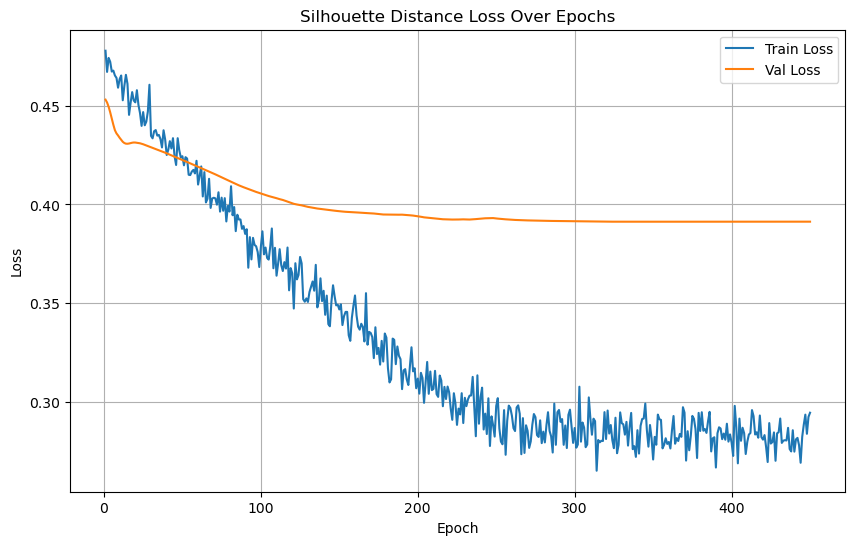

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2710
Test Batch [20/667], Loss: 0.2860
Test Batch [30/667], Loss: 0.3352


Test Batch [40/667], Loss: 0.4490
Test Batch [50/667], Loss: 0.2923
Test Batch [60/667], Loss: 0.3623
Test Batch [70/667], Loss: 0.2688


Test Batch [80/667], Loss: 0.2382
Test Batch [90/667], Loss: 0.2328
Test Batch [100/667], Loss: 0.2354
Test Batch [110/667], Loss: 0.2407


Test Batch [120/667], Loss: 0.2356
Test Batch [130/667], Loss: 0.2782
Test Batch [140/667], Loss: 0.1987
Test Batch [150/667], Loss: 0.2155
Test Batch [160/667], Loss: 0.2938


Test Batch [170/667], Loss: 0.2359
Test Batch [180/667], Loss: 0.5000
Test Batch [190/667], Loss: 0.2759
Test Batch [200/667], Loss: 0.5000
Test Batch [210/667], Loss: 0.5000
Test Batch [220/667], Loss: 0.3054
Test Batch [230/667], Loss: 0.2373
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000


Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.2751
Test Batch [320/667], Loss: 0.2075
Test Batch [330/667], Loss: 0.2523


Test Batch [340/667], Loss: 0.1937
Test Batch [350/667], Loss: 0.1795
Test Batch [360/667], Loss: 0.2512


Test Batch [370/667], Loss: 0.1822
Test Batch [380/667], Loss: 0.2579
Test Batch [390/667], Loss: 0.2023


Test Batch [400/667], Loss: 0.1684
Test Batch [410/667], Loss: 0.2366
Test Batch [420/667], Loss: 0.2502


Test Batch [430/667], Loss: 0.2152
Test Batch [440/667], Loss: 0.3395
Test Batch [450/667], Loss: 0.2492
Test Batch [460/667], Loss: 0.4358


Test Batch [470/667], Loss: 0.4262
Test Batch [480/667], Loss: 0.2883
Test Batch [490/667], Loss: 0.4023


Test Batch [500/667], Loss: 0.2059
Test Batch [510/667], Loss: 0.2912
Test Batch [520/667], Loss: 0.2823
Test Batch [530/667], Loss: 0.5000


Test Batch [540/667], Loss: 0.5000
Test Batch [550/667], Loss: 0.3052
Test Batch [560/667], Loss: 0.2963


Test Batch [570/667], Loss: 0.3363
Test Batch [580/667], Loss: 0.2185
Test Batch [590/667], Loss: 0.3025
Test Batch [600/667], Loss: 0.4519


Test Batch [610/667], Loss: 0.3312
Test Batch [620/667], Loss: 0.3224
Test Batch [630/667], Loss: 0.3955
Test Batch [640/667], Loss: 0.2134


Test Batch [650/667], Loss: 0.4246
Test Batch [660/667], Loss: 0.3986

Test Loss: 0.3205


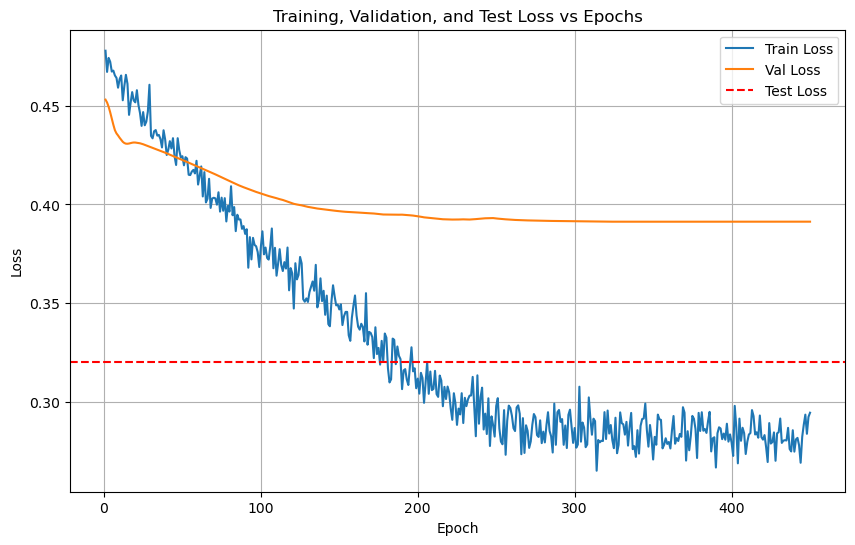

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.


  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.


  Processed batch 70/667 for test dataset.
  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.


  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.


  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.


  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.


  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.


  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.
  Processed batch 260/667 for test dataset.


  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.
  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.


  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.


  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.
  Processed batch 370/667 for test dataset.


  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.
  Processed batch 440/667 for test dataset.


  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.
  Processed batch 470/667 for test dataset.


  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.


  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.


  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.


  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.


  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 66.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.29      0.40      0.33         5
           2       0.67      0.80      0.73         5
           3       1.00      0.20      0.33         5
           4       1.00      0.80      0.89         5
           5       0.50      0.60      0.55         5
           6       0.67      0.80      0.73         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.67        45
   macro avg       0.73      0.67      0.66        45
weighted avg       0.73      0.67      0.66        45


LOG: Evaluating on the test set...
Test Accuracy: 60.56%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2027  |  Val Loss: 2.2029
Validation loss improved from inf to 2.2029.
[Epoch 2/1000] Train Loss: 2.1915  |  Val Loss: 2.1949
Validation loss improved from 2.2029 to 2.1949.
[Epoch 3/1000] Train Loss: 2.1805  |  Val Loss: 2.1871
Validation loss improved from 2.1949 to 2.1871.
[Epoch 4/1000] Train Loss: 2.1696  |  Val Loss: 2.1794
Validation loss improved from 2.1871 to 2.1794.
[Epoch 5/1000] Train Loss: 2.1588  |  Val Loss: 2.1718
Validation loss improved from 2.1794 to 2.1718.
[Epoch 6/1000] Train Loss: 2.1482  |  Val Loss: 2.1643
Validation loss improved from 2.1718 to 2.1643.
[Epoch 7/1000] Train Loss: 2.1377  |  Val Loss: 2.1569
Validation loss improved from 2.1643 to 2.1569.
[Epoch 8/1000] Train Loss: 2.1272  |  Val Loss: 2.1496
Validation loss improved from 2.1569 to 2.1496.
[Epoch 9/1000] Train Loss: 2.1168  |  Val Loss: 2.1425
Validation loss improved from 2.1496 to 2.1425.
[Epoch 10/1000] Train Loss: 2.1066  |  Val Loss: 2.1354
Validation loss impr

[Epoch 61/1000] Train Loss: 1.6924  |  Val Loss: 1.8449
Validation loss improved from 1.8495 to 1.8449.


[Epoch 62/1000] Train Loss: 1.6854  |  Val Loss: 1.8402
Validation loss improved from 1.8449 to 1.8402.
[Epoch 63/1000] Train Loss: 1.6785  |  Val Loss: 1.8356
Validation loss improved from 1.8402 to 1.8356.
[Epoch 64/1000] Train Loss: 1.6715  |  Val Loss: 1.8311
Validation loss improved from 1.8356 to 1.8311.
[Epoch 65/1000] Train Loss: 1.6645  |  Val Loss: 1.8268
Validation loss improved from 1.8311 to 1.8268.
[Epoch 66/1000] Train Loss: 1.6575  |  Val Loss: 1.8225
Validation loss improved from 1.8268 to 1.8225.
[Epoch 67/1000] Train Loss: 1.6506  |  Val Loss: 1.8182
Validation loss improved from 1.8225 to 1.8182.
[Epoch 68/1000] Train Loss: 1.6437  |  Val Loss: 1.8139
Validation loss improved from 1.8182 to 1.8139.
[Epoch 69/1000] Train Loss: 1.6369  |  Val Loss: 1.8096
Validation loss improved from 1.8139 to 1.8096.
[Epoch 70/1000] Train Loss: 1.6300  |  Val Loss: 1.8053
Validation loss improved from 1.8096 to 1.8053.
[Epoch 71/1000] Train Loss: 1.6231  |  Val Loss: 1.8011
Validati

[Epoch 133/1000] Train Loss: 1.2036  |  Val Loss: 1.5574
Validation loss improved from 1.5611 to 1.5574.
[Epoch 134/1000] Train Loss: 1.1970  |  Val Loss: 1.5537
Validation loss improved from 1.5574 to 1.5537.
[Epoch 135/1000] Train Loss: 1.1905  |  Val Loss: 1.5500
Validation loss improved from 1.5537 to 1.5500.
[Epoch 136/1000] Train Loss: 1.1839  |  Val Loss: 1.5464
Validation loss improved from 1.5500 to 1.5464.
[Epoch 137/1000] Train Loss: 1.1774  |  Val Loss: 1.5427
Validation loss improved from 1.5464 to 1.5427.
[Epoch 138/1000] Train Loss: 1.1709  |  Val Loss: 1.5390
Validation loss improved from 1.5427 to 1.5390.
[Epoch 139/1000] Train Loss: 1.1644  |  Val Loss: 1.5354
Validation loss improved from 1.5390 to 1.5354.
[Epoch 140/1000] Train Loss: 1.1579  |  Val Loss: 1.5317
Validation loss improved from 1.5354 to 1.5317.
[Epoch 141/1000] Train Loss: 1.1514  |  Val Loss: 1.5281
Validation loss improved from 1.5317 to 1.5281.
[Epoch 142/1000] Train Loss: 1.1449  |  Val Loss: 1.524

[Epoch 203/1000] Train Loss: 0.7934  |  Val Loss: 1.3339
Validation loss improved from 1.3363 to 1.3339.
[Epoch 204/1000] Train Loss: 0.7883  |  Val Loss: 1.3316
Validation loss improved from 1.3339 to 1.3316.
[Epoch 205/1000] Train Loss: 0.7833  |  Val Loss: 1.3293
Validation loss improved from 1.3316 to 1.3293.
[Epoch 206/1000] Train Loss: 0.7783  |  Val Loss: 1.3271
Validation loss improved from 1.3293 to 1.3271.
[Epoch 207/1000] Train Loss: 0.7734  |  Val Loss: 1.3249
Validation loss improved from 1.3271 to 1.3249.
[Epoch 208/1000] Train Loss: 0.7684  |  Val Loss: 1.3227
Validation loss improved from 1.3249 to 1.3227.
[Epoch 209/1000] Train Loss: 0.7635  |  Val Loss: 1.3205
Validation loss improved from 1.3227 to 1.3205.
[Epoch 210/1000] Train Loss: 0.7585  |  Val Loss: 1.3184
Validation loss improved from 1.3205 to 1.3184.
[Epoch 211/1000] Train Loss: 0.7536  |  Val Loss: 1.3162
Validation loss improved from 1.3184 to 1.3162.
[Epoch 212/1000] Train Loss: 0.7487  |  Val Loss: 1.314

[Epoch 283/1000] Train Loss: 0.4549  |  Val Loss: 1.2174
Validation loss improved from 1.2180 to 1.2174.
[Epoch 284/1000] Train Loss: 0.4516  |  Val Loss: 1.2169
Validation loss improved from 1.2174 to 1.2169.
[Epoch 285/1000] Train Loss: 0.4483  |  Val Loss: 1.2163
Validation loss improved from 1.2169 to 1.2163.
[Epoch 286/1000] Train Loss: 0.4450  |  Val Loss: 1.2157
Validation loss improved from 1.2163 to 1.2157.
[Epoch 287/1000] Train Loss: 0.4418  |  Val Loss: 1.2152
Validation loss improved from 1.2157 to 1.2152.
[Epoch 288/1000] Train Loss: 0.4386  |  Val Loss: 1.2147
Validation loss improved from 1.2152 to 1.2147.
[Epoch 289/1000] Train Loss: 0.4354  |  Val Loss: 1.2142
Validation loss improved from 1.2147 to 1.2142.
[Epoch 290/1000] Train Loss: 0.4322  |  Val Loss: 1.2137
Validation loss improved from 1.2142 to 1.2137.
[Epoch 291/1000] Train Loss: 0.4291  |  Val Loss: 1.2132
Validation loss improved from 1.2137 to 1.2132.
[Epoch 292/1000] Train Loss: 0.4259  |  Val Loss: 1.212

[Epoch 361/1000] Train Loss: 0.2547  |  Val Loss: 1.2072
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 362/1000] Train Loss: 0.2528  |  Val Loss: 1.2074
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 363/1000] Train Loss: 0.2510  |  Val Loss: 1.2076
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 364/1000] Train Loss: 0.2491  |  Val Loss: 1.2078
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 365/1000] Train Loss: 0.2473  |  Val Loss: 1.2080
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 366/1000] Train Loss: 0.2455  |  Val Loss: 1.2083
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 367/1000] Train Loss: 0.2438  |  Val Loss: 1.2085
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 368/1000] Train Loss: 0.2420  |  Val Loss: 1.2088
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 369/1000] Train Loss: 0.2402  |  Val Loss: 1.2090
!! Validation loss did NOT improve !! Patience:

[Epoch 438/1000] Train Loss: 0.1512  |  Val Loss: 1.2550
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 439/1000] Train Loss: 0.1503  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 440/1000] Train Loss: 0.1494  |  Val Loss: 1.2568
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 441/1000] Train Loss: 0.1485  |  Val Loss: 1.2577
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 442/1000] Train Loss: 0.1477  |  Val Loss: 1.2586
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 443/1000] Train Loss: 0.1468  |  Val Loss: 1.2596
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 444/1000] Train Loss: 0.1459  |  Val Loss: 1.2605
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 445/1000] Train Loss: 0.1451  |  Val Loss: 1.2615
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 445 !!
No improvement for 100 epochs.


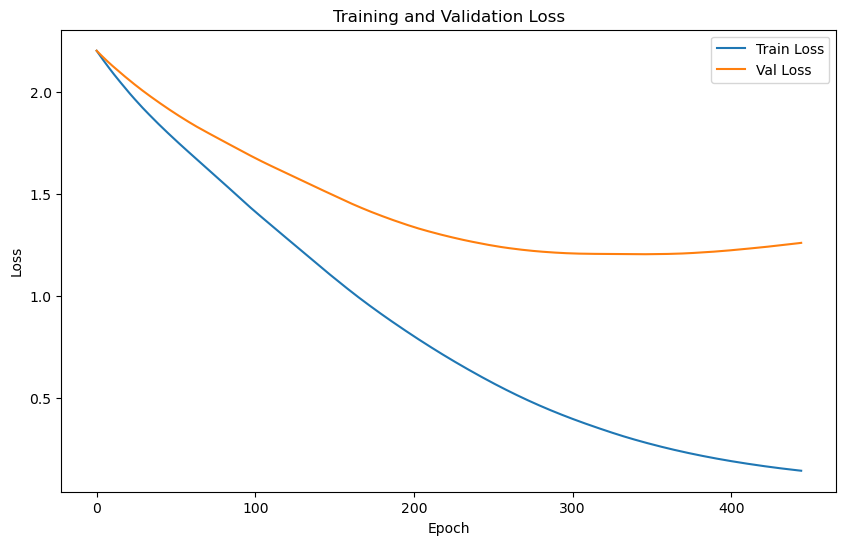

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.6126 | Test Accuracy: 61.17%


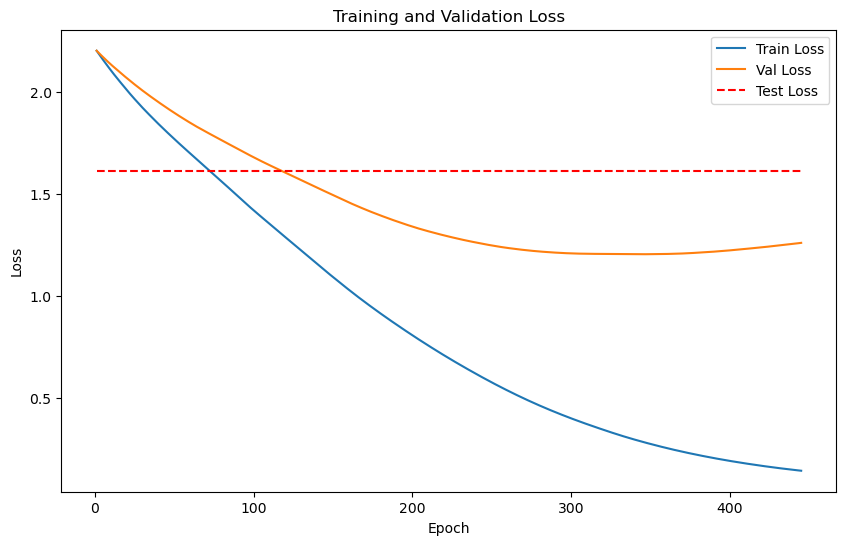

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


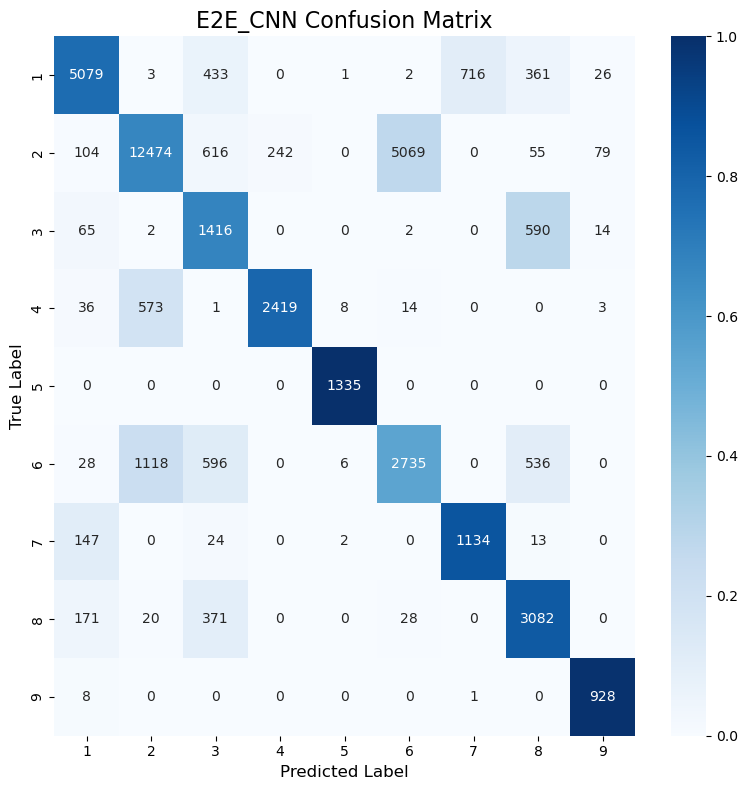

Classification Accuracy: 71.69%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


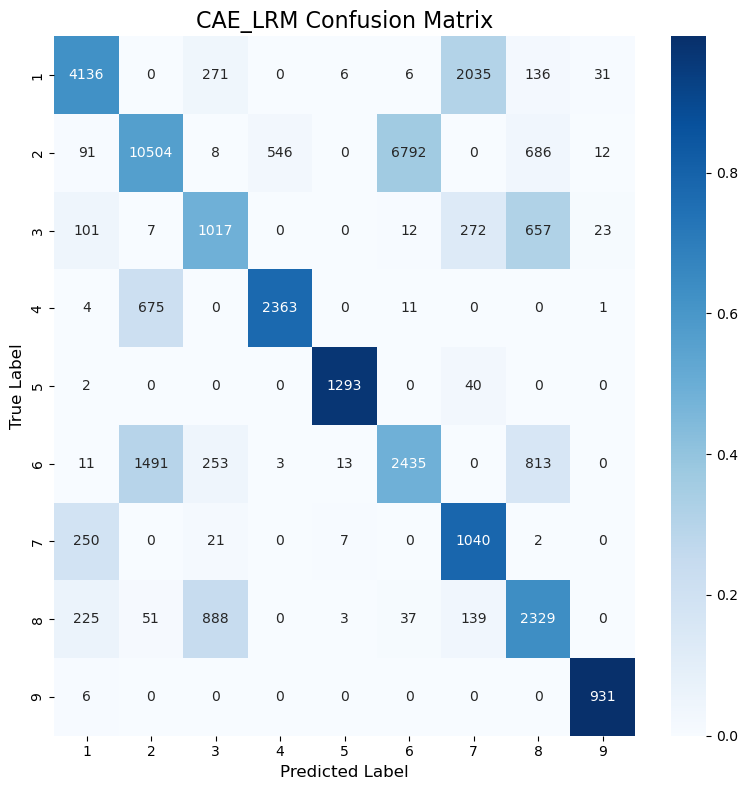

Classification Accuracy: 61.02%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


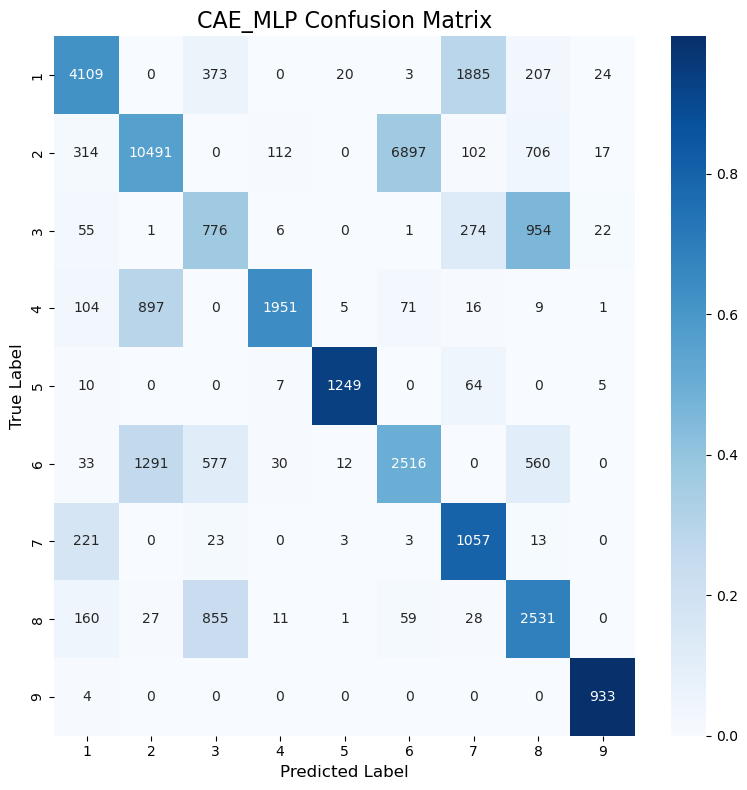

Classification Accuracy: 60.00%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


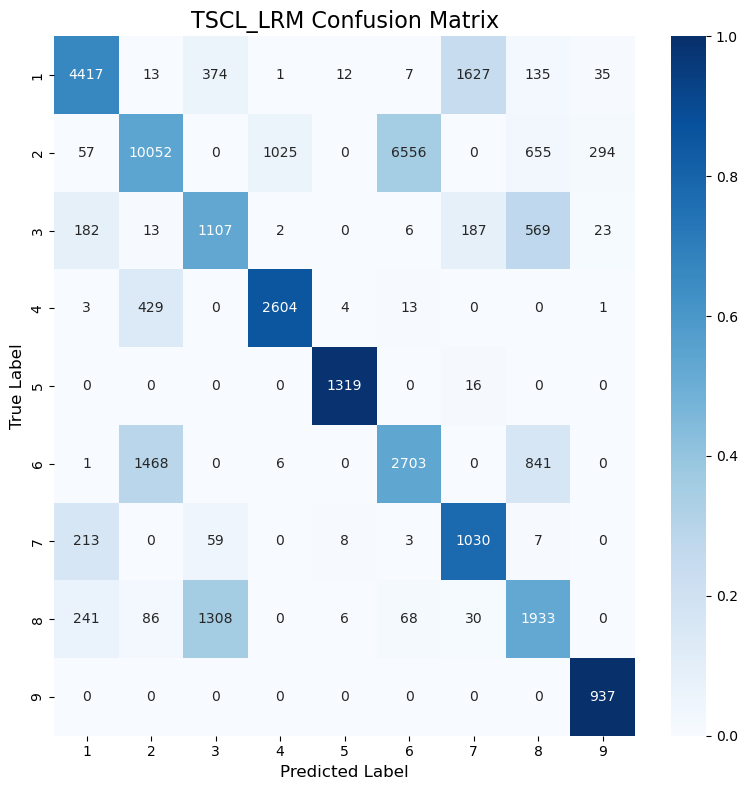

Classification Accuracy: 61.15%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


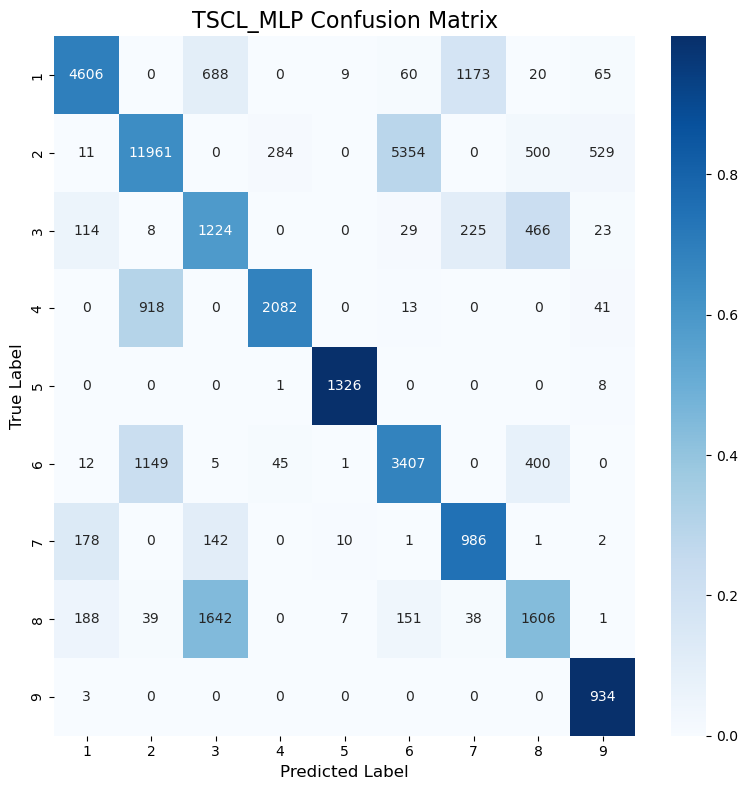

Classification Accuracy: 65.90%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


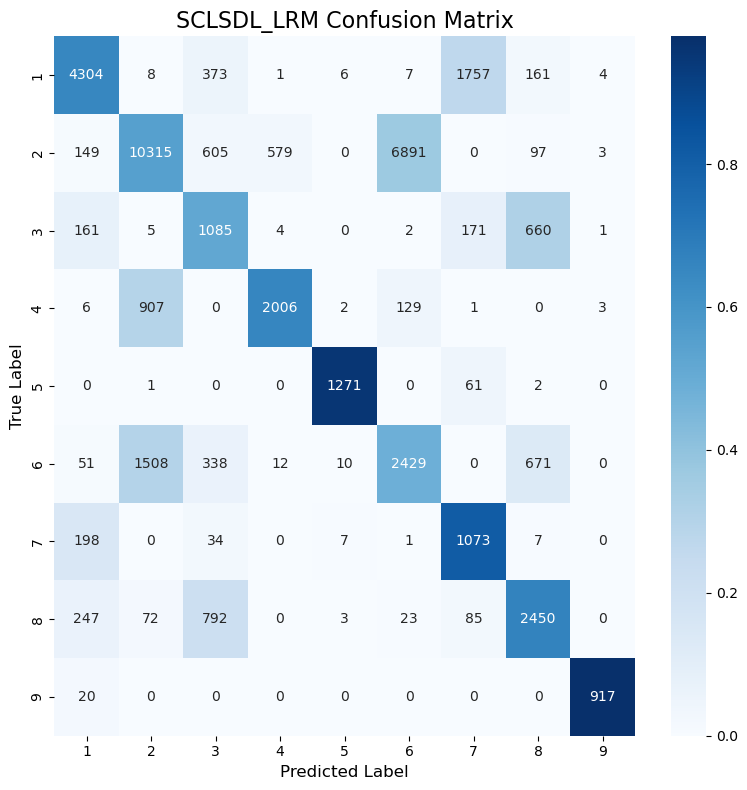

Classification Accuracy: 60.56%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


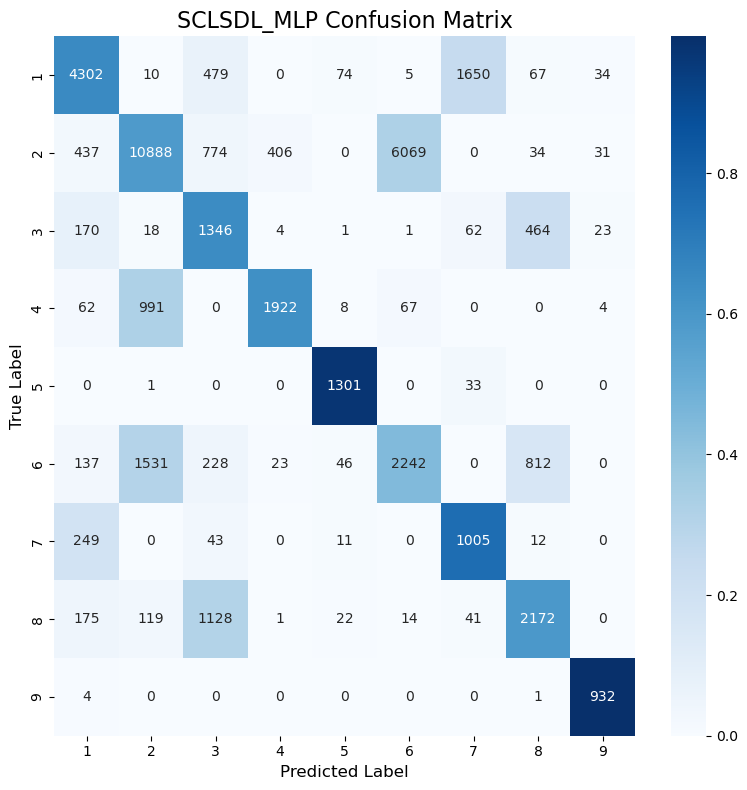

Classification Accuracy: 61.17%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          71.69
1    LRM (CAE)          61.02
2    MLP (CAE)          60.00
3     TSCL LRM          61.15
4     TSCL MLP          65.90
5  SCL_SDL LRM          60.56
6  SCL_SDL MLP          61.17

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          71.69
4     TSCL MLP          65.90
6  SCL_SDL MLP          61.17
3     TSCL LRM          61.15
1    LRM (CAE)          61.02
5  SCL_SDL LRM          60.56
2    MLP (CAE)          60.00
